In [1]:
from functions import *

In [2]:
path = ".\dhi_data2"

In [3]:
#path = "d:\moje_dokumenty\Desktop\matfyz\mgr\semester 11\Projektovy seminar\dhi_data2"   ## Alex's path

In [4]:
files = os.listdir(path)

In [5]:
dataframes_dict = load_series(path)

In [6]:
site_dataframes = merge_site_data(dataframes_dict)
site_dataframes = clean_data(site_dataframes)

In [7]:
first_path = ".\Q01_HL_23.csv"
rain_path = ".\SR02_H2_27374.csv"

#first_path = "d:\moje_dokumenty\Desktop\matfyz\mgr\semester 11\Projektovy seminar\Q01_HL_23.csv"   ## Alex's path
#rain_path = "d:\moje_dokumenty\Desktop\matfyz\mgr\semester 11\Projektovy seminar\SR02_H2_27374.csv"    ## Alex's path

In [8]:
first_data = pd.read_csv(first_path, skiprows=[0,1,2, 3],
                   names = ["date"," Hl-Vega-OK", "Hl-US-Odlehc", "Hladina KDO", "Teplota KDO", 
                                       "Rychlost KDO", "Prietok_l", "Napatie_AKU2", "Napatie_AKU",  "prutok_computed"],
                  sep = ";", decimal=',')

rain = pd.read_csv(rain_path, skiprows=[0,1,2, 3],
                  usecols = [0,1], names = ["date","rain"],
                  sep = ";", decimal=',')

first_data["date"] = pd.to_datetime(first_data['date'], format='%d.%m.%Y %H:%M:%S')
rain["date"] = pd.to_datetime(rain['date'], format='%d.%m.%Y %H:%M:%S')
rain.replace(r'^\s*$', np.nan, regex=True, inplace=True)
rain["rain"] = pd.to_numeric(rain["rain"].str.replace(',', '.') )

rain.set_index('date', inplace=True)

# Resample data to two-minute intervals and calculate the sum for each two-minute period
rain['rain_2m'] = rain['rain'].resample('2T').sum()

# Assign NaN to odd minutes
rain['rain_2m'][rain.index.minute % 2 != 0] = np.nan

rain["date"] = rain.index
rain.index = range(rain.shape[0])
first_data = first_data.merge(rain, on='date', how='left')

In [9]:
site_dataframes["first"] = first_data

In [12]:
explorer = DataExplorer(site_dataframes)

In [13]:
vars_of_interest = {}

for key in site_dataframes:
    df = site_dataframes[key]
    nas = df.isna().sum()
    goods = list(nas[nas==0].index)
    goods.remove("date")
    goods.remove("prutok_computed")
    vars_of_interest[key] = goods
    

del vars_of_interest["first"] 
print(vars_of_interest)

{'MP1': ['hladina_result', 'rychlost_result'], 'MP3': ['hladina_result', 'rychlost_result'], 'MP2': ['hladina_result', 'rychlost_result'], 'MP4': ['hladina_result', 'rychlost_result'], 'MP7': ['hladina_TL_zdroj', 'rychlost_zdroj'], 'MP5': ['hladina_result', 'rychlost_result'], 'MP6': ['hladina_result', 'rychlost_result']}


In [14]:
explorer.classify()
# classification of velocity and level
outs = explorer.classify(classif_vars_dict = vars_of_interest)

In [15]:
ts_data = explorer.TS_objects['first'].copy() 
ts_data.classify()

In [18]:
subset_1 = ts_data.data["date"].dt.date == pd.to_datetime("2022-06-04").date()
subset1 = ts_data.data[subset_1].index

In [17]:
subset_ = ts_data.data["date"].dt.date == pd.to_datetime("2022-06-11").date()
subset2 = ts_data.data[subset_].index

In [57]:
subset_ = ts_data.data["date"].dt.date == pd.to_datetime("2022-06-02").date()
subset3 = ts_data.data[subset_].index
subset_ = ts_data.data["date"].dt.date == pd.to_datetime("2022-06-03").date()
subset4 = ts_data.data[subset_].index
subset5 = ts_data.data[subset_1|subset_].index

subset_ = ts_data.data["date"].dt.date == pd.to_datetime("2022-06-06").date()
subset6 = ts_data.data[subset_].index

In [60]:
ee.data =  correct_data(ee.data, ee.main_var)
rr.data =  correct_data(rr.data, rr.main_var)

# Agenda
* events and their identification updates
* correction of errors implementation updates
* code and library structure
* feedback, others

notation: 

$v_t$ denotes flow at time $t$

$\Delta v_t$ denotes first differences of flow

MA$_t$(W) denotes centred moving average with window size W measured at time $t$

Msd$_t$(W) denotes centred moving standard deviation with window size W measured at time $t$

# Events
 - outliers, zero or constant values, and periods of heightened volatility
 
Just heuristical rules for identification, some are quite rough. Could be optimized if we had specific targets to aim for.

### outliers
Flow values which seems odd compared to nearby past and future values. $v_t$ is identified as outlier if flow jumped by high margin up and then immediately fell by high margin down (or vice versa, fell and than rised back), i.e.
$$ \Delta v_t > T_t \qquad \text{and} \qquad \Delta v_{t+1} < -T_t $$
or both inequalities in the opposite direction.

Threshold is based on moving standard deviation **of the first differences of the flow** as 
$$ T_t = c_1 \cdot Msd_t(W_1). $$
We use as default values $c_1 = 2.5$ and window $W_1 = 30$.

**data requirements**: for Msd we need $W_1$ observations, that is we can identify outliers with 15 periods = **30 minutes delay** with the default choice of $W_1$ but should probably work well with smaller windows, too.

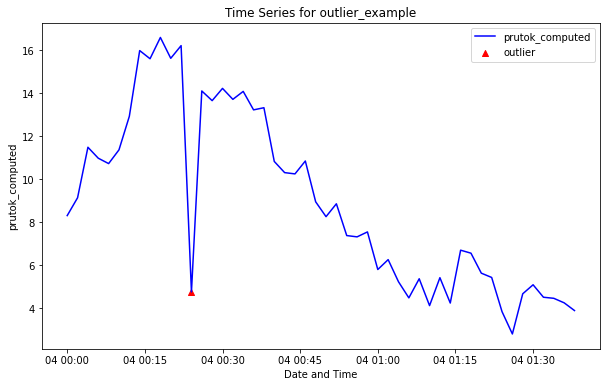

In [15]:
plot_categories(ts_data.data.loc[subset1[:50]], "prutok_computed", "outlier_example", categories = ["outlier"])

### Zero and constant values
Zero values are simply those for which $v_t = 0$. We identify constant observations as those which have not changed in comparison to past and future, i.e. observation at $t$ is constant if $v_{t-1} = v_t = v_{t+1}$. Technically, this is done by identifying zero moving standard deviation of the flow  with window 3,
$$ Msd_t(W_0) = 0 $$
with $W_0 = 3$. However, we recognize constant values only if there is at least $tol\_const = 5$ of them in succession, otherwise they are ignored as regular observations. Generally, we can be also more lenient by setting $W_0$ to some higher value.

**data requirements**: immediate identification of zero values and delay of only 1 period for constant values.

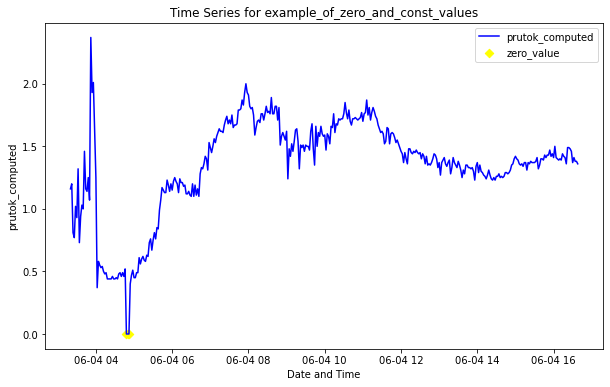

In [21]:
plot_categories(ts_data.data.loc[subset1[100:500]], "prutok_computed", "example_of_zero_and_const_values")

### example of difference in number of constant_values groups and observations 

In [22]:
rr=TS_Class(explorer.TS_objects["MP2"].data)
rr.classify(tol_const=1)

In [30]:
rr.data =  correct_data(rr.data, rr.main_var)

In [23]:
summarize_event_groups(rr.data, classif_var="prutok_computed").iloc[1,]

category      const_value
count              2890.0
count_perc        0.04362
max_group          1047.0
mean_group       5.197842
med_group             1.0
min_group             1.0
no_groups           556.0
Name: 1, dtype: object

In [24]:
summarize_event_groups(explorer.TS_objects["MP2"].data, classif_var="prutok_computed").iloc[1,]

category      const_value
count              2193.0
count_perc         0.0331
max_group          1047.0
mean_group         91.375
med_group             8.5
min_group             5.0
no_groups            24.0
Name: 1, dtype: object

### periods of high volatility
Sometimes, flow is suspiciously volatile. We identify this by high values of its (or rather of its first differences') moving standard deviation,
$$ Msd_t(W_2) > K $$
where we chose window $W_2 = 30$. Threshold is determined as overall standard deviation for lower 0.7 quantile of flow observations (rough controlling for rain disturbances),
$$ K = c_2 \cdot \sigma_{p_1} $$
with $c_2 = 1$ and $p_1 = 0.7$, $\sigma_{p_1} = sd(v_t; v_t \leq p_1\text{th quantile of the (first diffs. of the) flow})$. These are default values, choosing lower $p_1$ or $c_2$ would be more sensitive to heightened volatility and vice versa.

We furthemore identify groups of high volatility observations (successive periods in which high volatility is recognized) and if there are two groups seperated by less then $tol\_vol_1 = 5$ non-volatile observations we merge them by setting observations between them as high-volatility observations as well. On the other hand if a group of highly volatile observations has less then $tol\_vol_2 = 5$ members we deem it as a false signal and categorize them as OK.

**data requirements:** We need $W_2$ observations for moving standard deviation calculations, i.e. **delay of 15 periods** at default setting. But we also need to have set the threshold $K$ for which we use the whole history of the data. If necessary could be set expertly to some reasonable value.

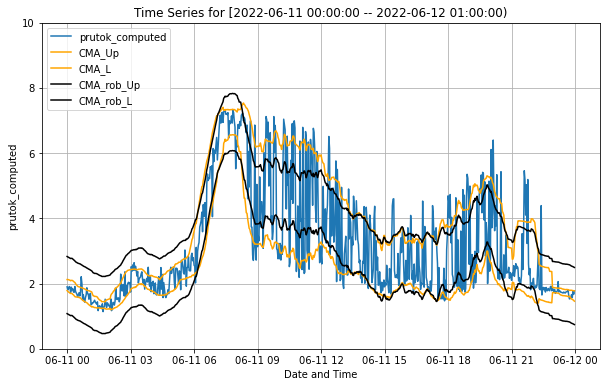

In [18]:
ts_data.plot(include=["CMA_rob_bounds","CMA_bounds"], period=25, start_time="0:00:00", subset = subset2,
            rob_b_mult = 1, rob_quantile=0.7)

### difference between measuring volatility on the main variables vs its differences

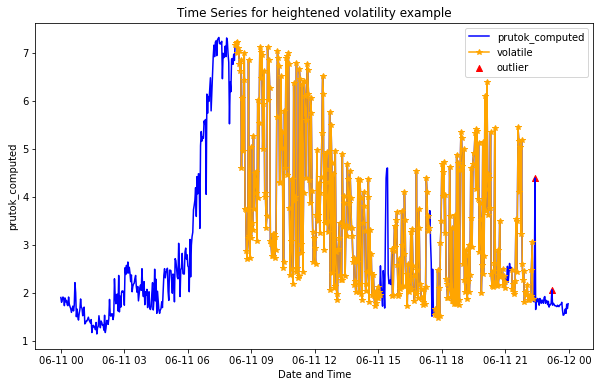

In [32]:
plot_categories(ts_data.data.loc[subset2], "prutok_computed", "heightened volatility example")  # FD based

In [31]:
ee=TS_Class(explorer.TS_objects["first"].data)
ee.classify(volatile_diffs=False)
ee.data =  correct_data(ee.data, ee.main_var)

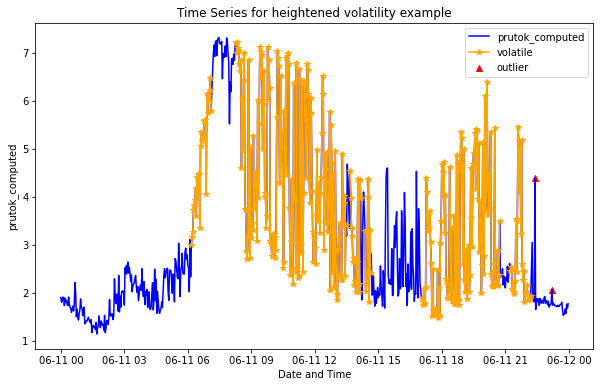

In [33]:
plot_categories(ee.data.loc[subset2], "prutok_computed", "heightened volatility example")  # flow based

In [35]:
ts_data2 = explorer.TS_objects["MP2"]
subset_ = ts_data2.data["date"].dt.date == pd.to_datetime("2022-08-01").date()
subset3 = ts_data2.data[subset_].index

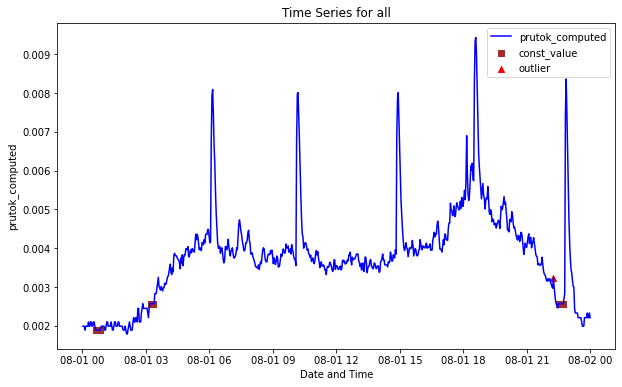

In [36]:
plot_categories(ts_data2.data.loc[subset3], "prutok_computed", "all")# volatility based on first differences of the flow

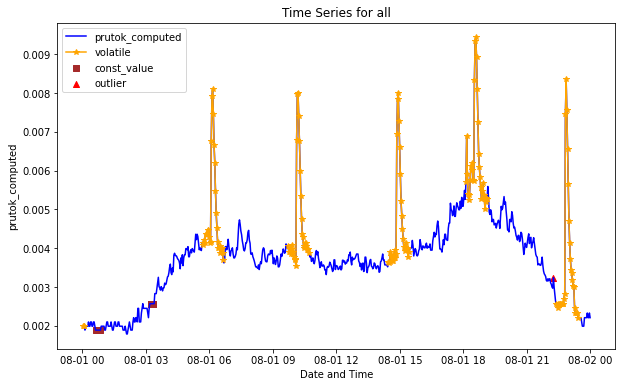

In [37]:
ts_data2_c = ts_data2.copy()
ts_data2_c.classify(volatile_diffs=False)  # volatility of flow itself
plot_categories(ts_data2_c.data.loc[subset3], "prutok_computed", "all")

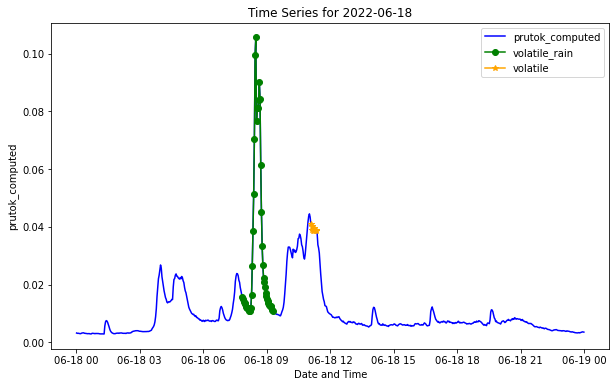

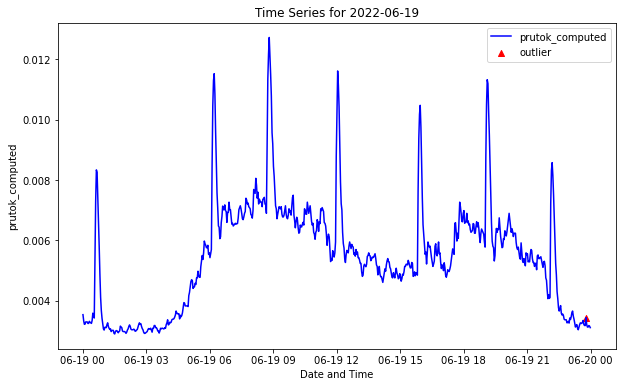

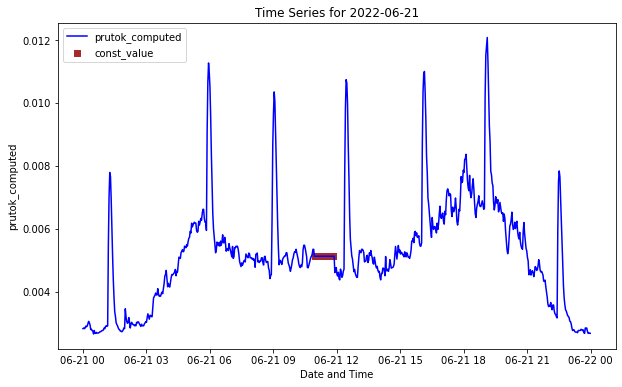

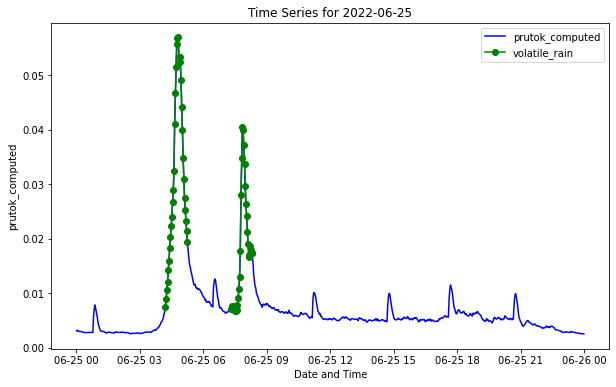

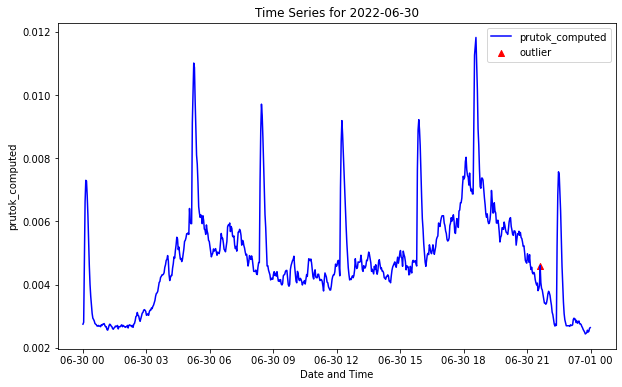

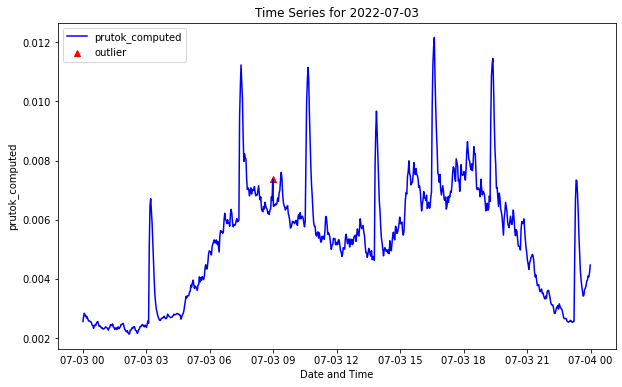

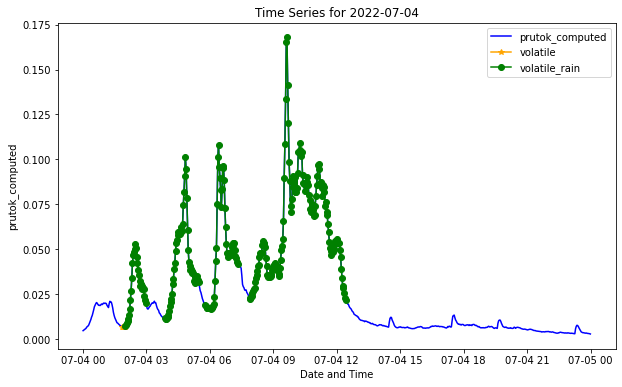

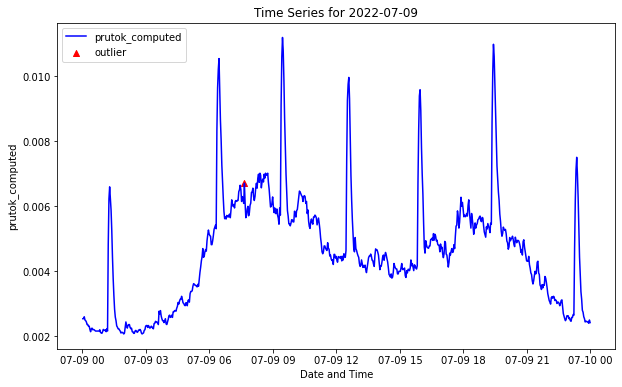

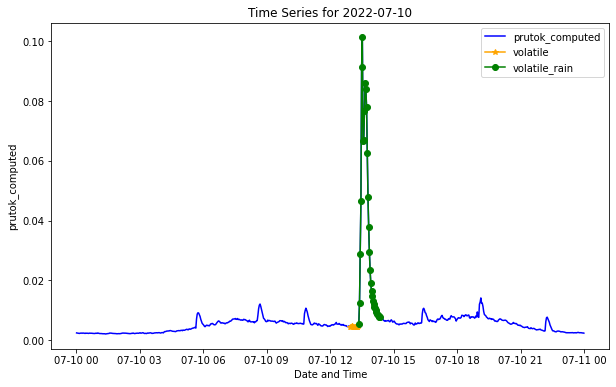

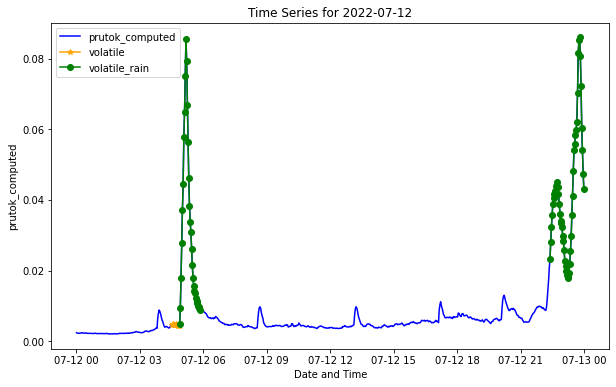

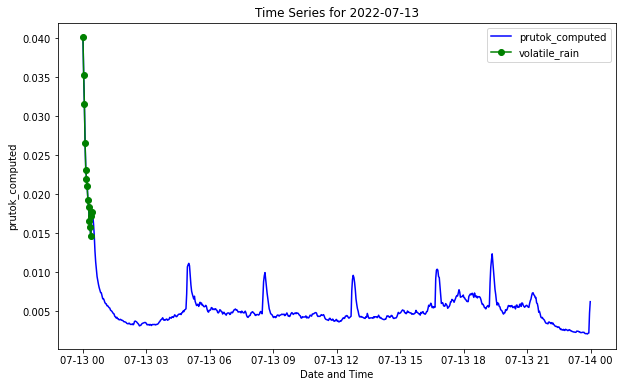

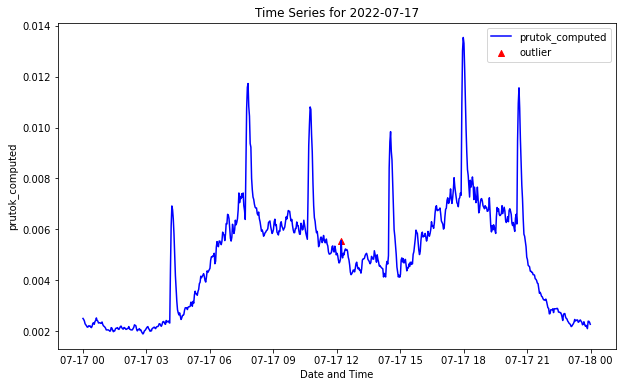

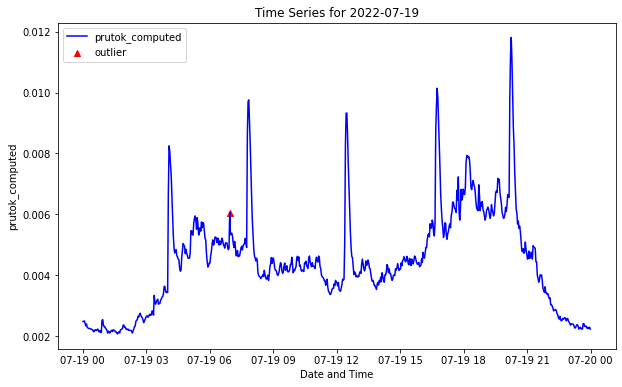

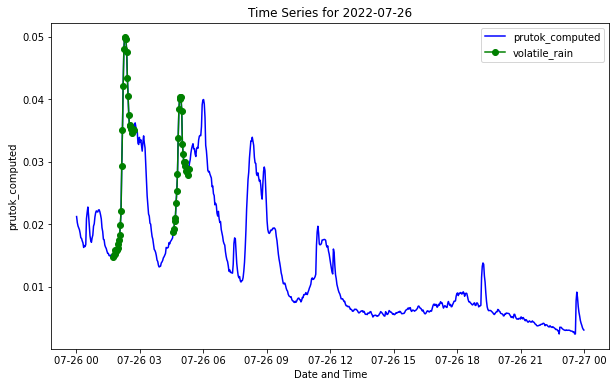

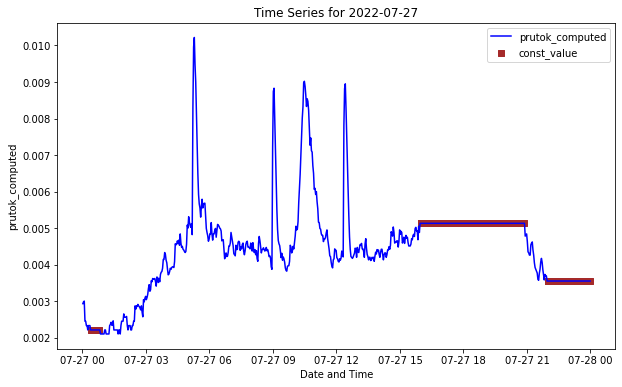

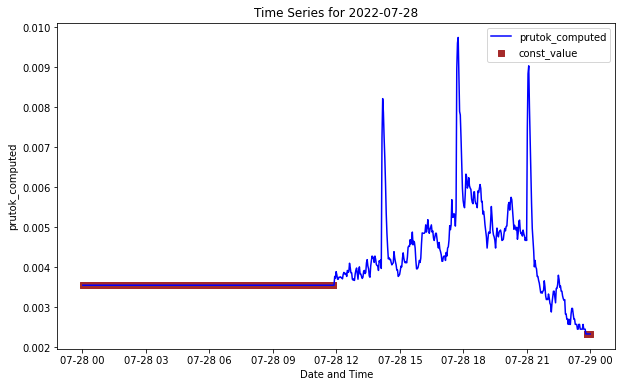

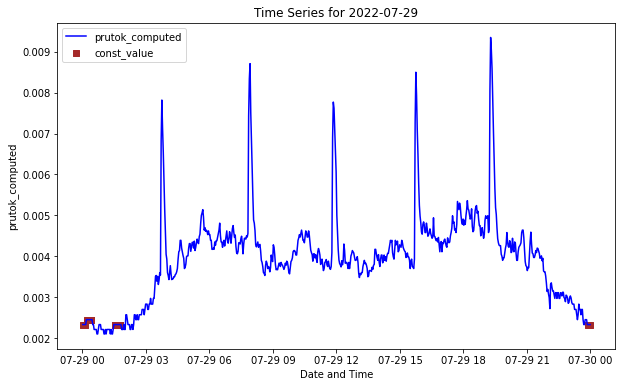

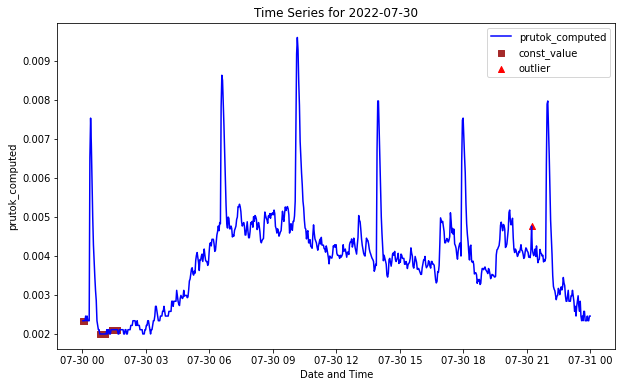

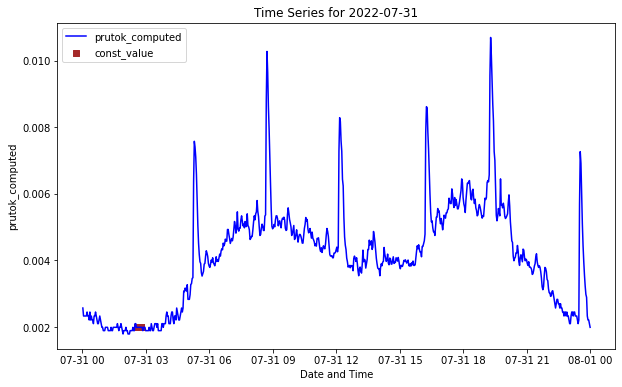

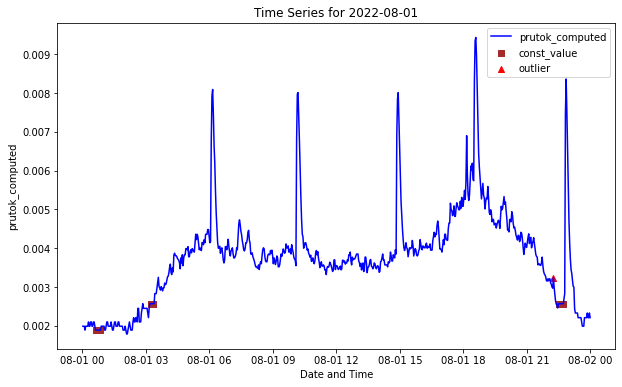

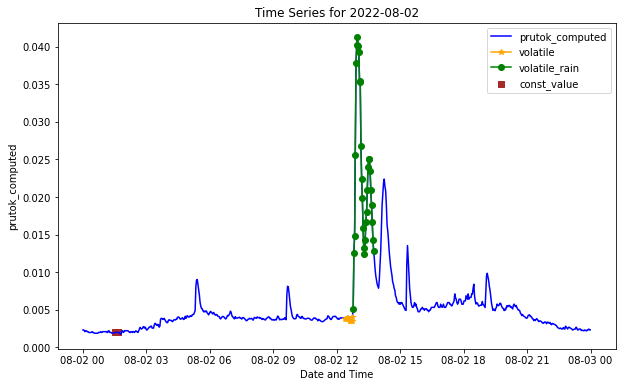

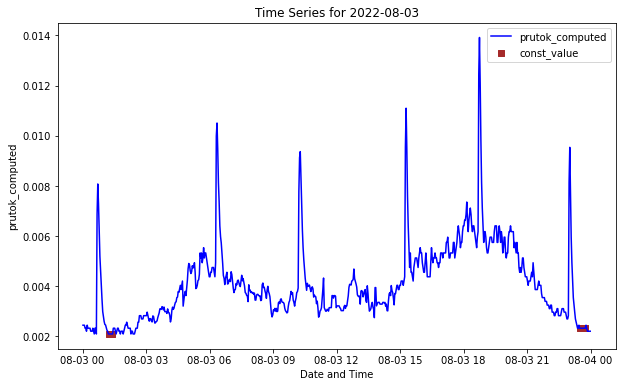

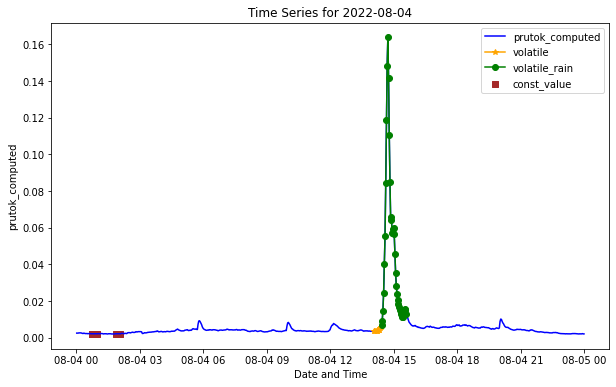

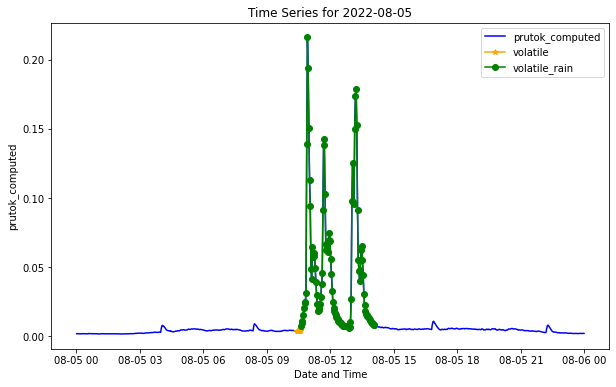

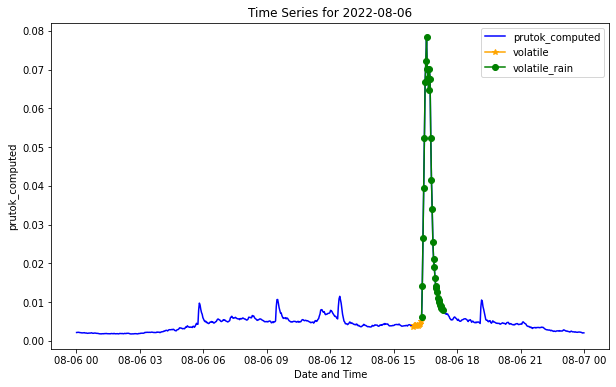

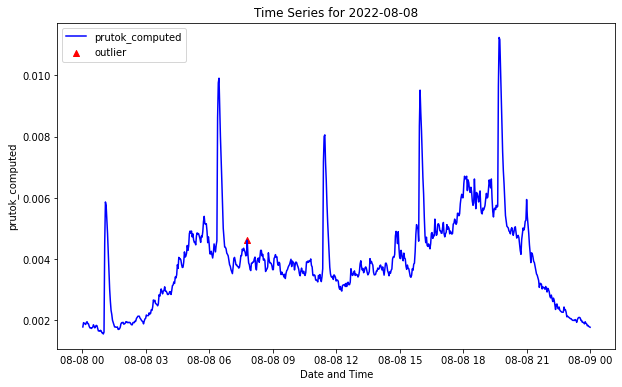

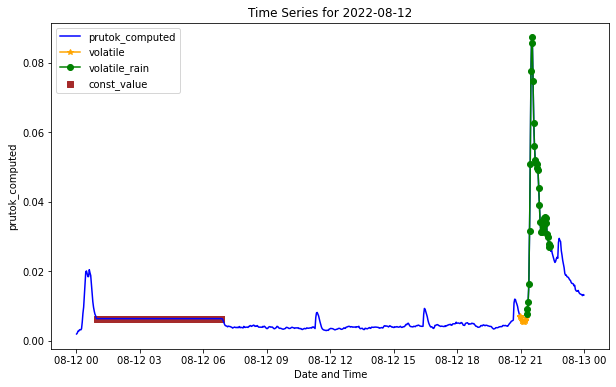

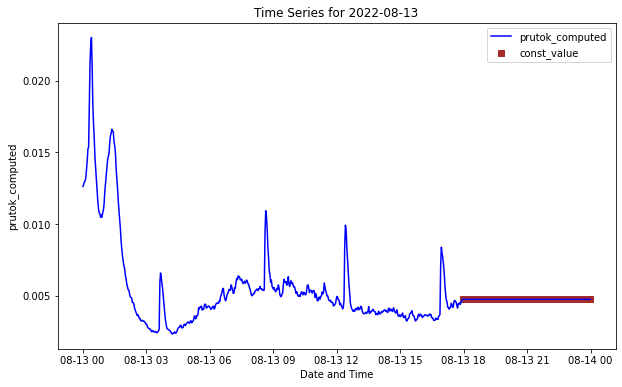

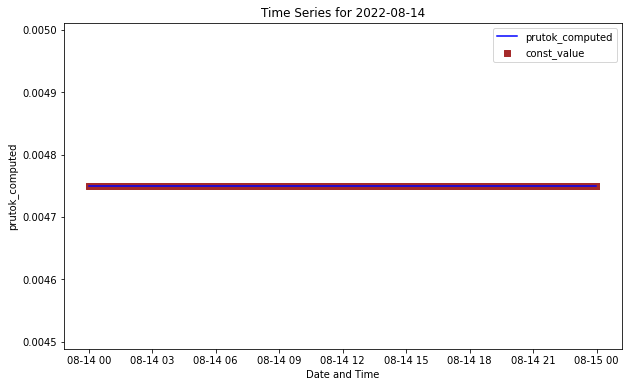

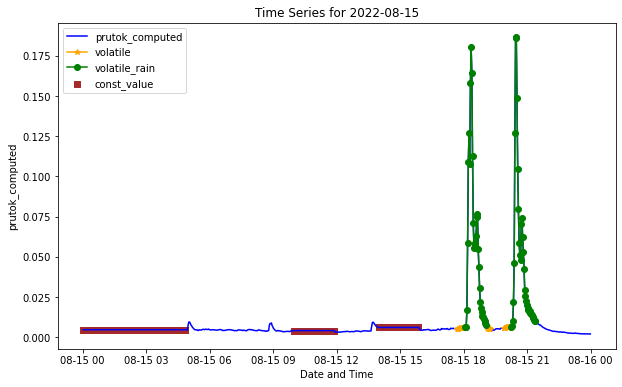

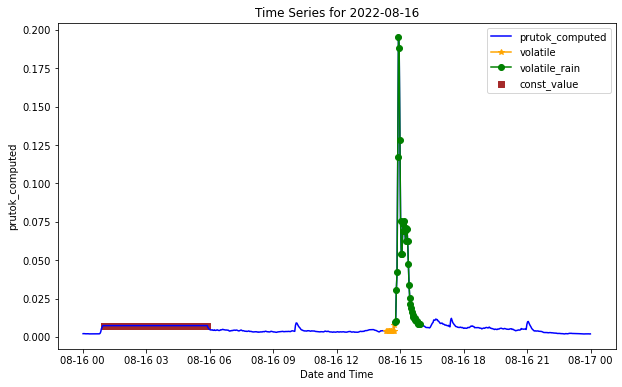

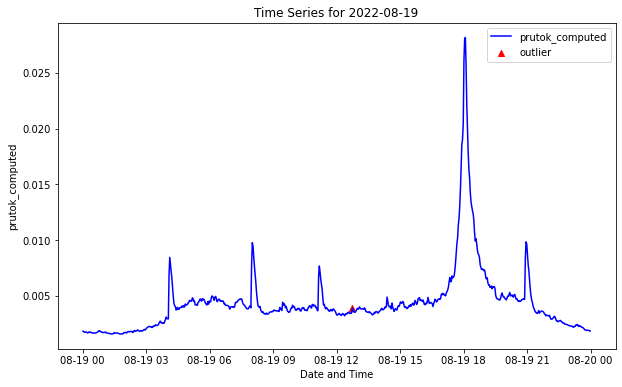

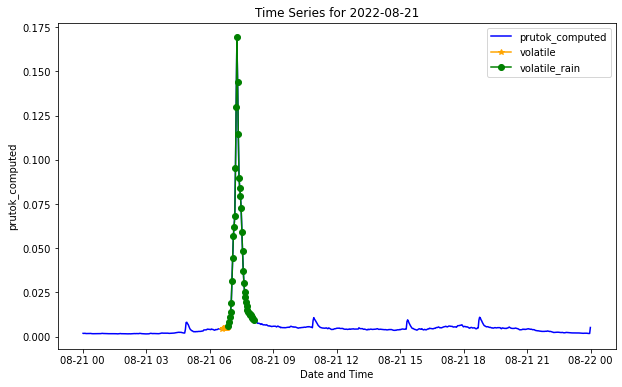

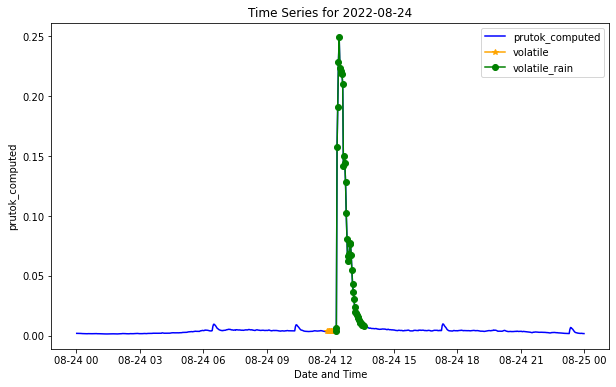

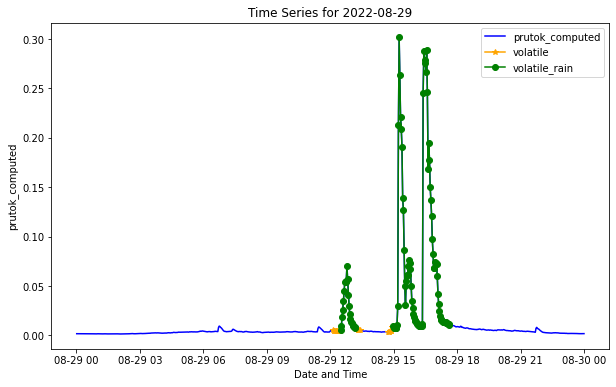

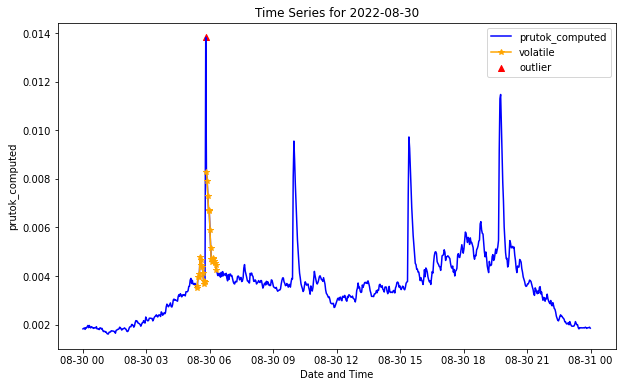

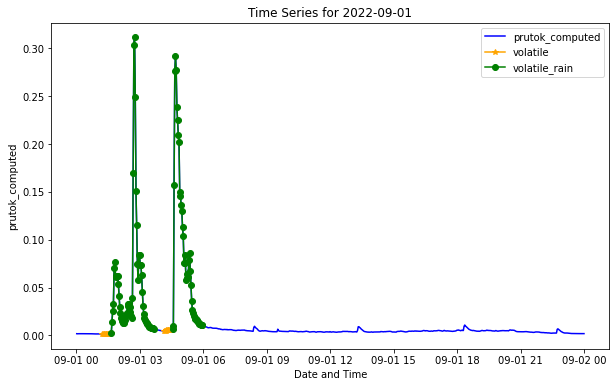

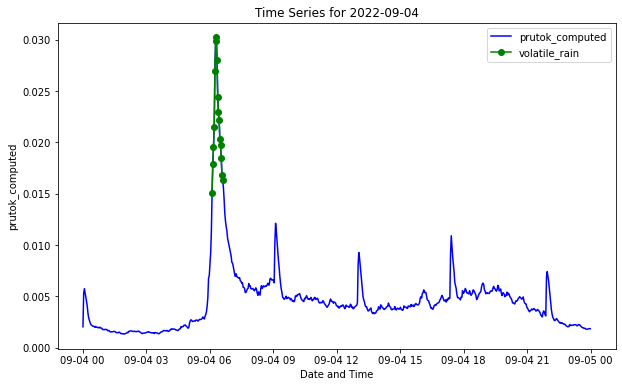

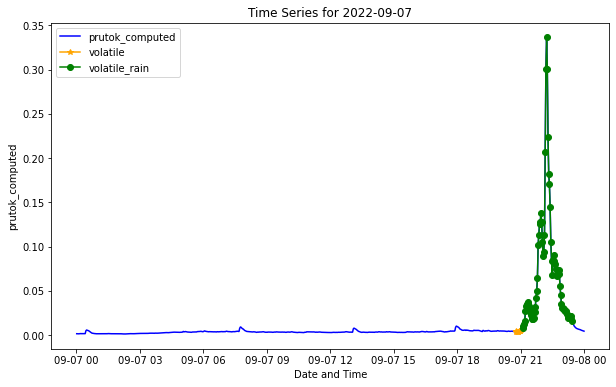

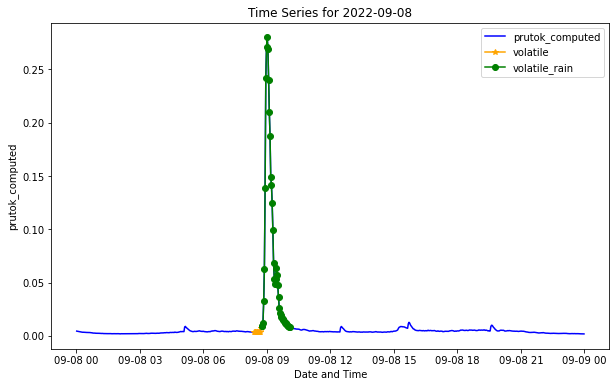

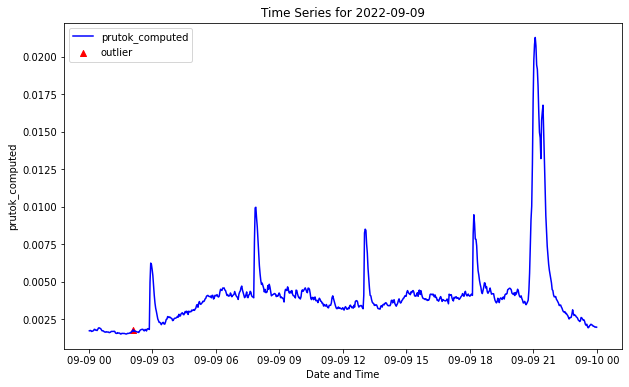

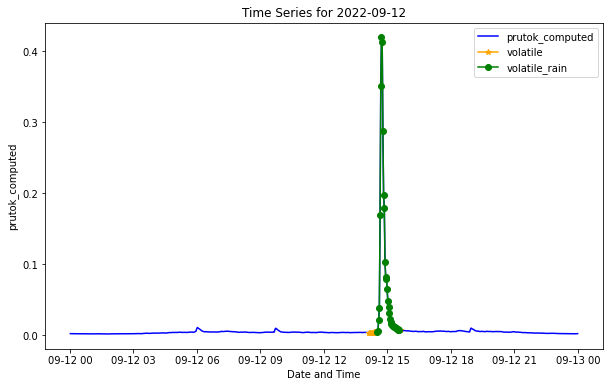

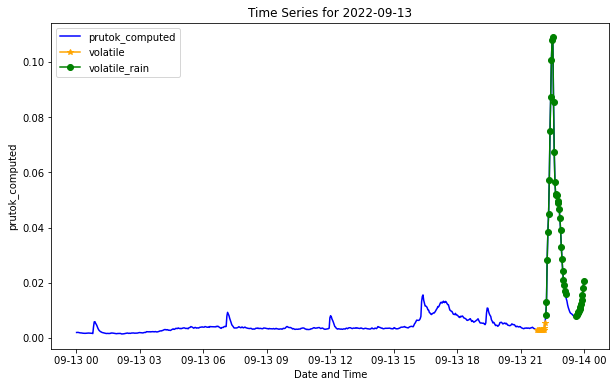

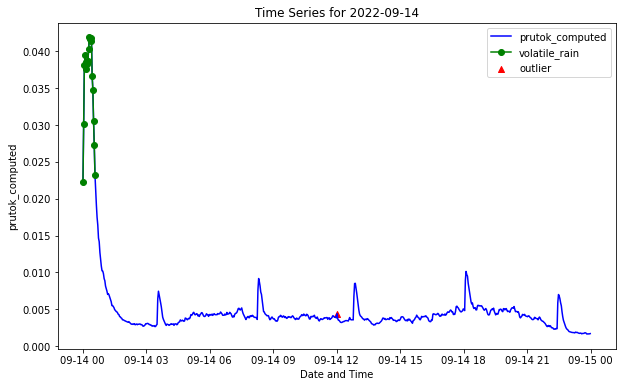

In [38]:
explorer.TS_objects["MP2"].plot_categories(period = "daily") # volatility based on first differences of the flow

### high volatility due to rain
When it is raining it is natural and OK that volatility is high. We thus try to recognize when this happens due to rain. Rain is usually accompanied by heightened level of the flow (here, we always use flow, not its first differences), hence we set conditions for this category as
$$ \text{heightened volatility and }  MA_t(W_3) \geq p_2\text{th percentile of the flow.} $$
As default we set $p_2 = 0.9$ and $W_3 = 5$.

We furthermore perform the same kind of grouping as for general high volatility, this time with $tol\_rain_1 = 5$ and $tol\_rain_2 = 10$.

**data requirements**: This category is subset of heightened volatility, so **same as above**. Additionally, we need moving average with window $W_3$ but this window is in default setting smaller than the one required for heightened volatility identification. We use the whole history of the data for calculating $p_2$th percentile of the flow but if necessary, this  could be replaced by some expertly chosen value.

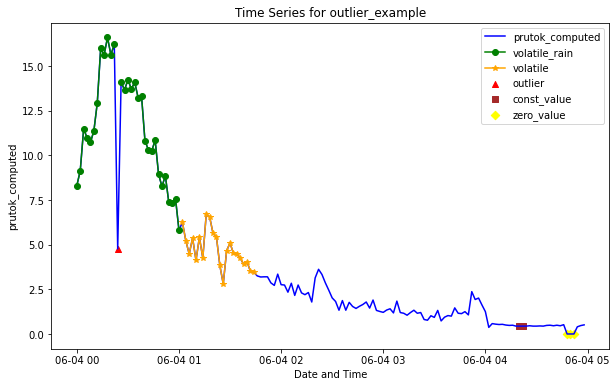

In [20]:
plot_categories(ts_data.data.loc[subset1[:150]], "prutok_computed", "outlier_example", categories = "all")

## Hierarchy of categories
We categorize each observation to just one group. Since an observation can sometimes satisfy conditions for multiple categories we set hierarchy as follows (from the most prefered category to the most overwritten):
1) outliers

2) zero values 

3) volatility due to rain

4) general volatility

5) constant values

Observations which do not belong to any of these categories are considered to be OK.

# Corrections

Not implemented yet (in few more days), only discussion:

* outliers: when isolated just replace $v_t$ by average($v_{t-1}, v_{t+1}$). If there are multiple outliers in succession  (does not usually happen) then apply MA(5) or MA(15). Hence usually **trivial data requirements**.

* high volatility due to rain: we suppose this is natural and apply **no correction** to this.

* high volatility: replacing $v_t$ with MA(5) or MA(15) in order to smooth the series and eliminate noise, hence only small data requirements - **delay of 3 or 8 periods**. It was mentioned that estimates of variance of errors would be welcomed - can be achieved by ARIMA models.

### zero or constant values: 
Most tricky category to repair, many different possibilities. Isolated instances or if there are only few successive observations (< 8) can be replaced e.g. by MA(15) or MA(30). 

For medium periodsof successive errors (8 to 30)  of this type standard ARIMA or ETS predictions can be reasonable solution. These can be estimated on historical data, window of 50-100 observations should be quite enough (if neccessary perhaps even as few as 30). 

For longer gaps in data it would be worthwile to try to estimate cyclical components. Our first approach is to use dummy estimates of cyclical components, other common possibility is to use sinusoids of different frequencies. Cycles can be computed e.g. for individual hours, days in the week, week/weekends, day/night... expert suggestions are welcomed! Naturally, such approach requires longer data history, depending on type of assumed cycles.

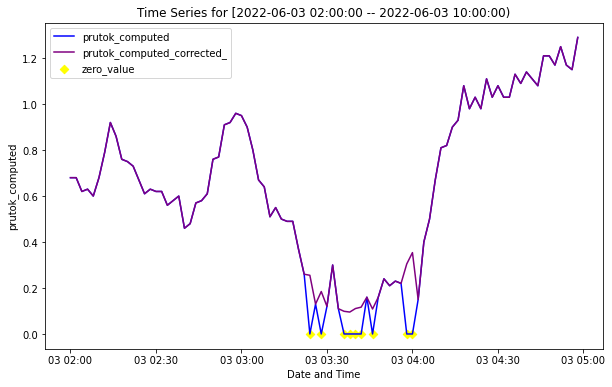

In [43]:
ee.plot_categories(period=8, corrections=ee.main_var+"_corrected_", subset=subset4[60:150])

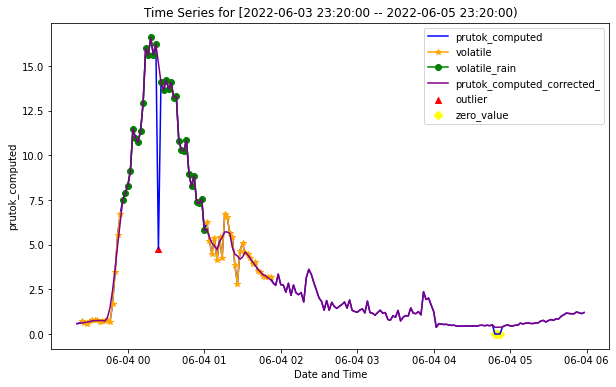

In [55]:
ee.plot_categories(period=48, corrections=ee.main_var+"_corrected_", subset=subset5[700:900])

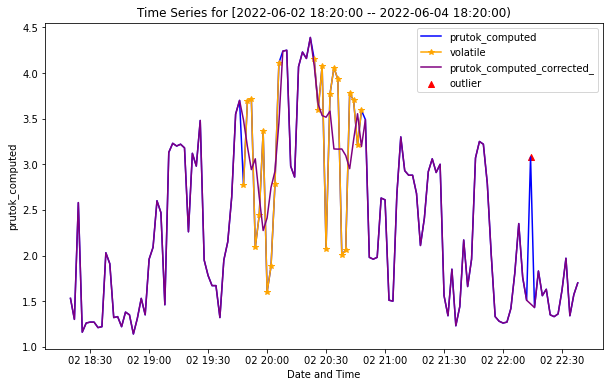

In [64]:
ee.plot_categories(period=48, corrections=ee.main_var+"_corrected_", subset=subset3[550:680])

# Further examples

### categorization of individual received time series
rough illustration on the whole data

MP1


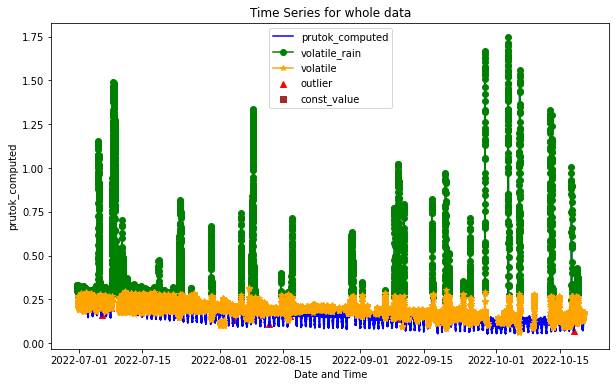

MP2


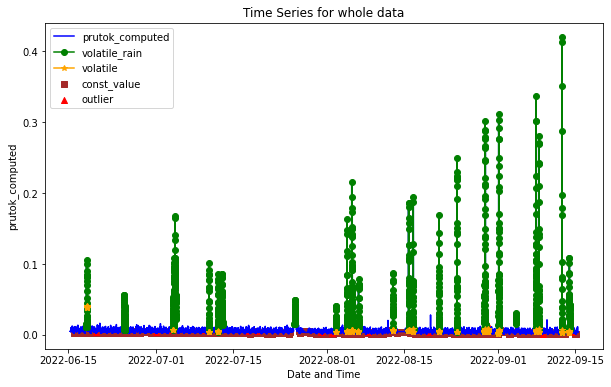

MP3


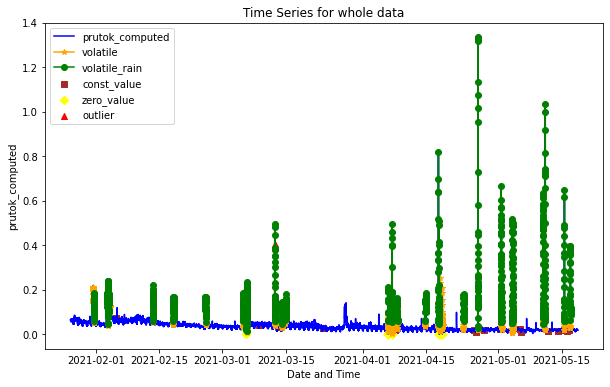

MP4


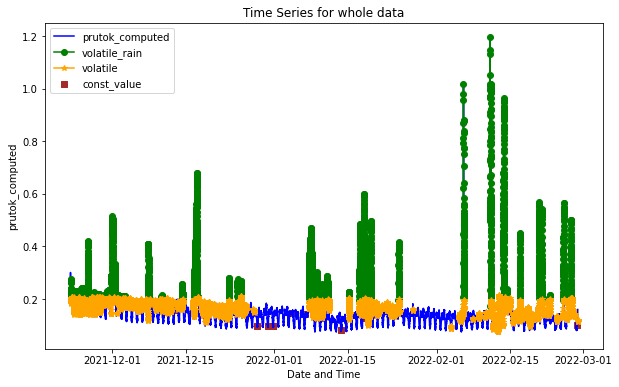

MP5


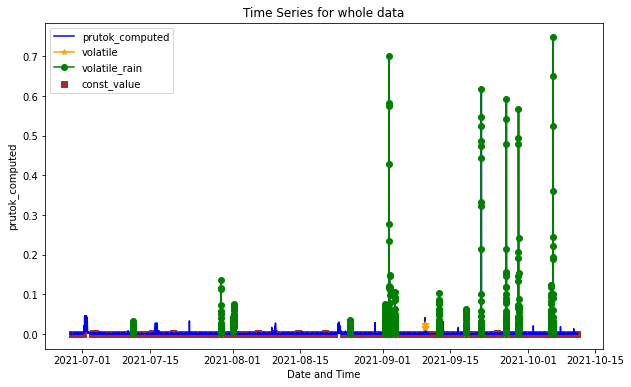

MP6


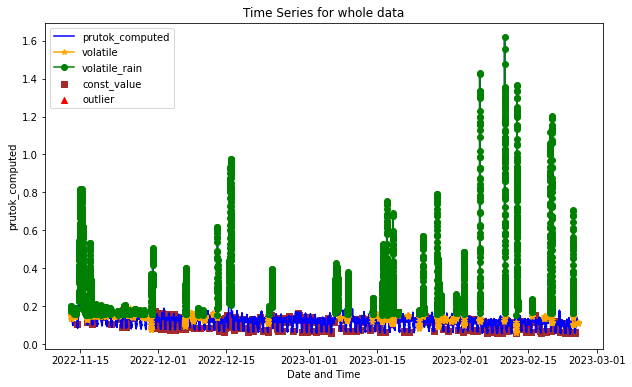

MP7


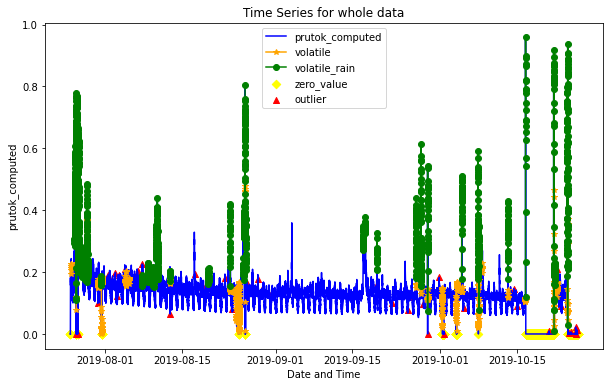

first


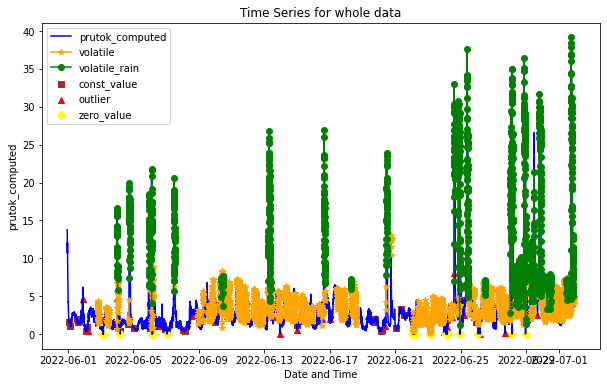

In [21]:
for site in explorer.main_sites:
    print(site)
    explorer.TS_objects[site].plot_categories()

### level and velocity

MP1
hladina_result


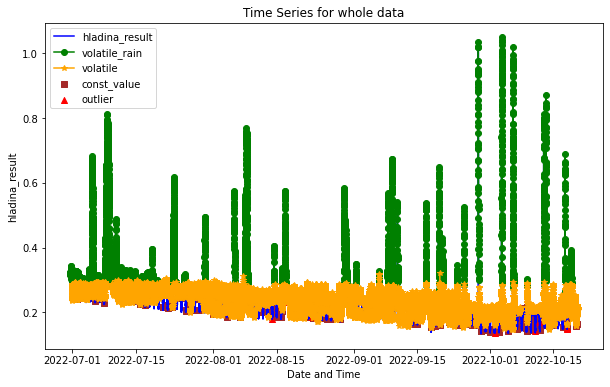

rychlost_result


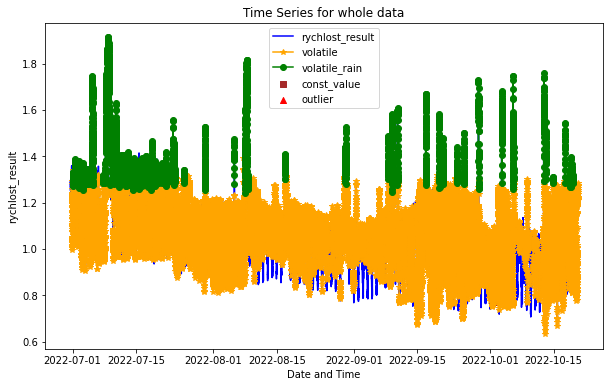

MP2
hladina_result


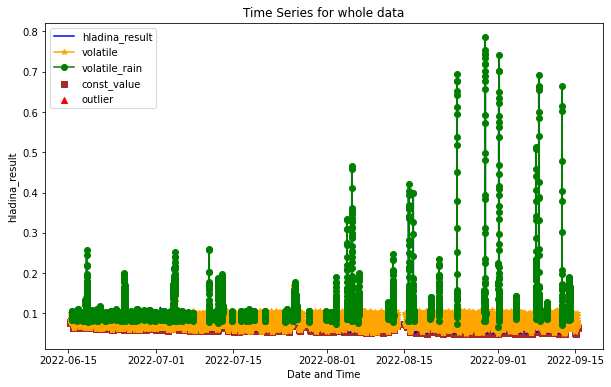

rychlost_result


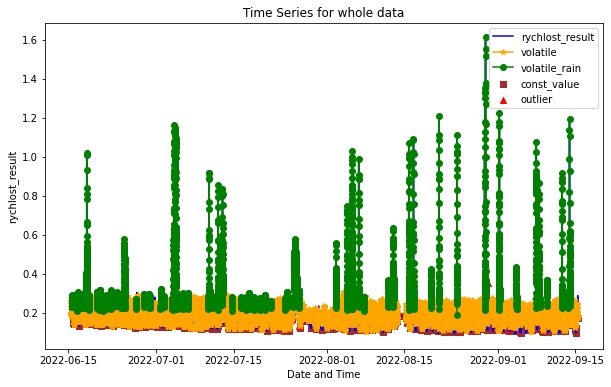

MP3
hladina_result


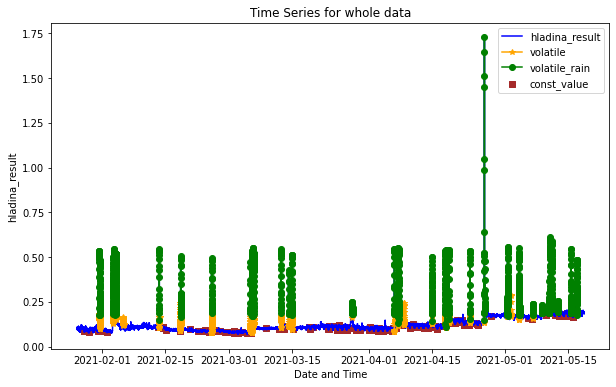

rychlost_result


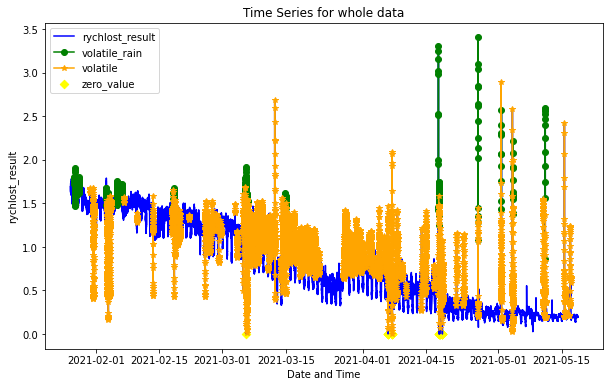

MP4
hladina_result


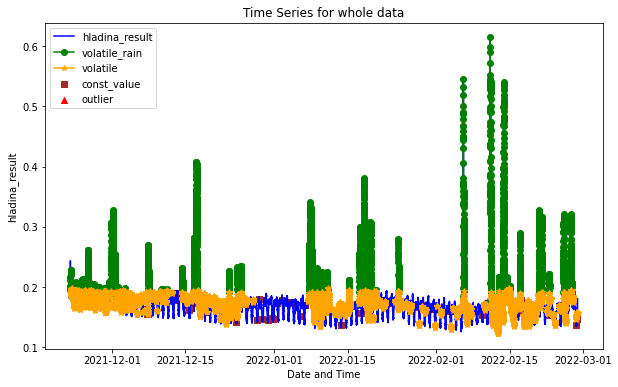

rychlost_result


C:\Users\am\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


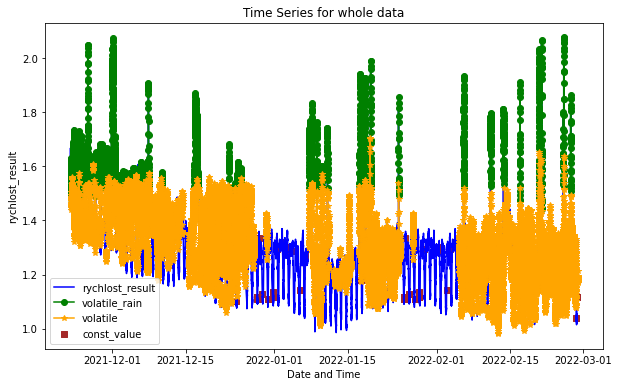

MP5
hladina_result


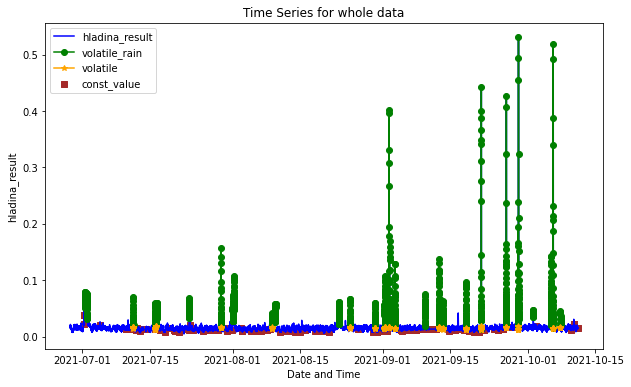

rychlost_result


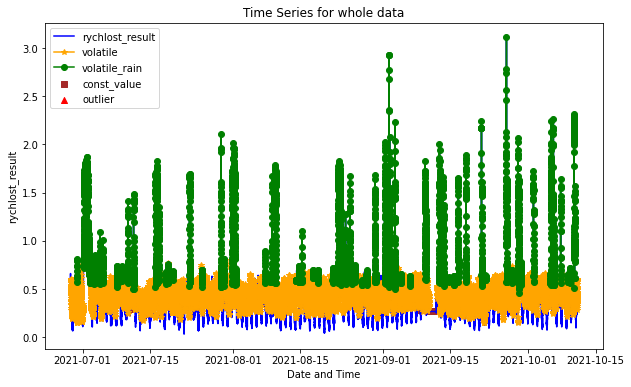

MP6
hladina_result


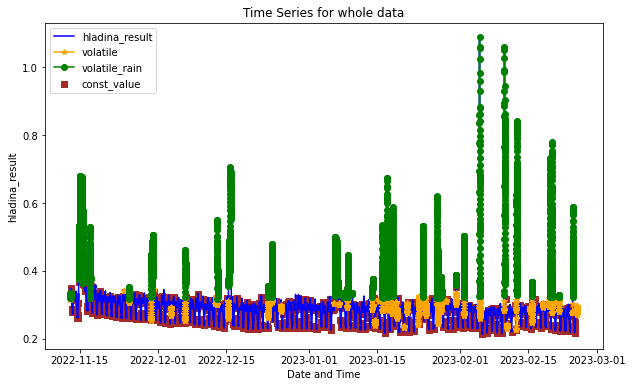

rychlost_result


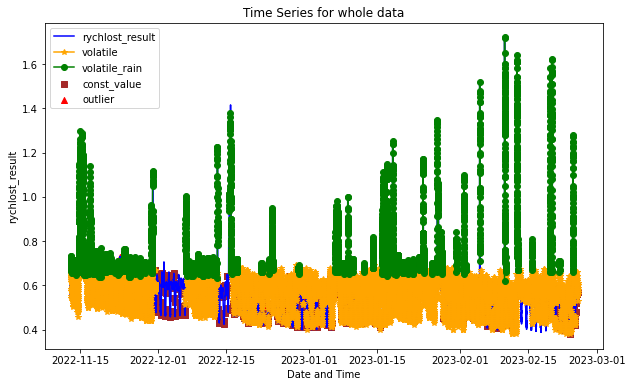

MP7
hladina_TL_zdroj


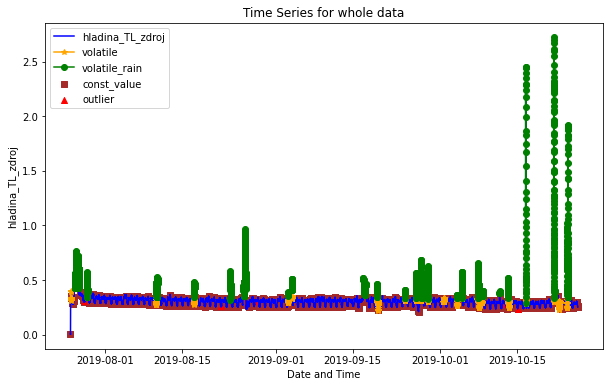

rychlost_zdroj


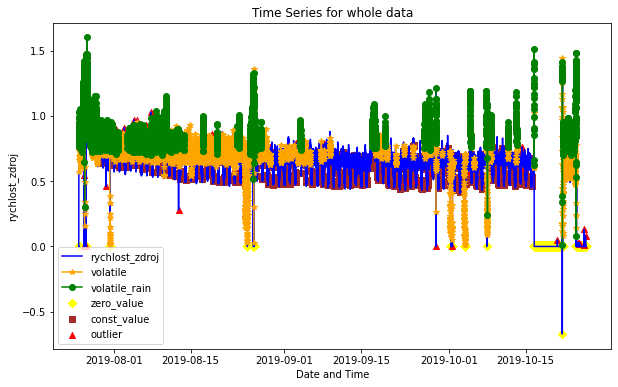

first


In [29]:
for site in explorer.main_sites:
    print(site)
    if site == "first":
        continue
    for var in vars_of_interest[site]:
        print(var)
        explorer.TS_objects[site].plot_categories(classif_var=var)

In [30]:
ts_data2 = explorer.TS_objects["MP2"]
subset_ = ts_data2.data["date"].dt.date == pd.to_datetime("2022-08-01").date()
subset3 = ts_data2.data[subset_].index

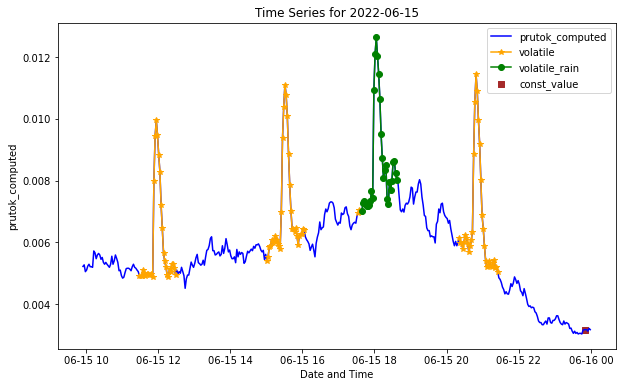

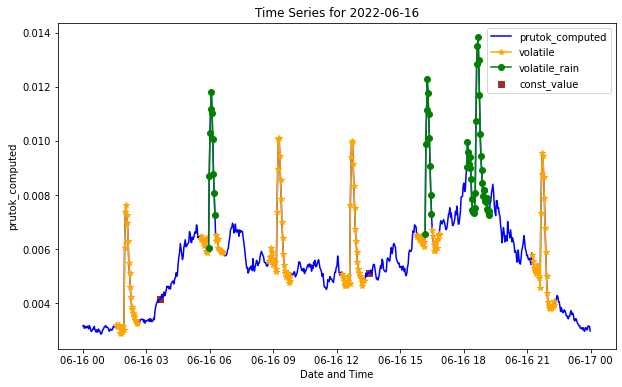

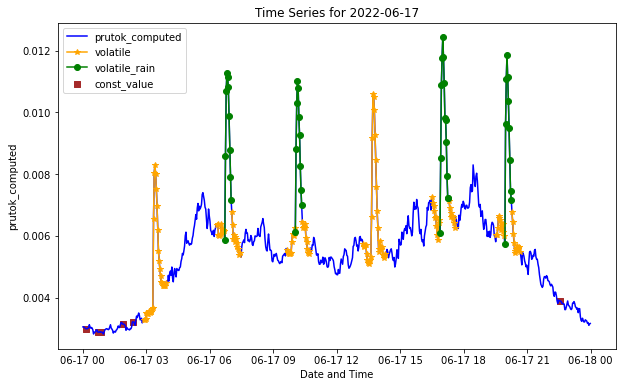

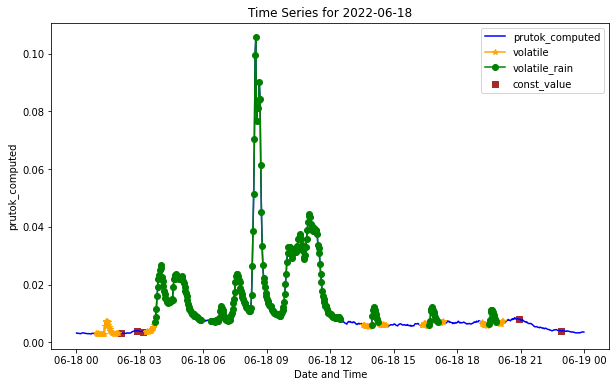

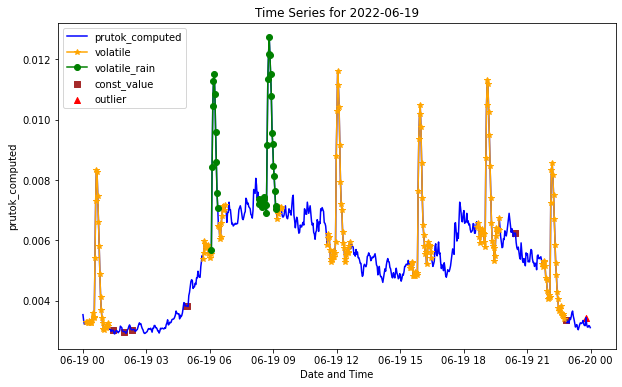

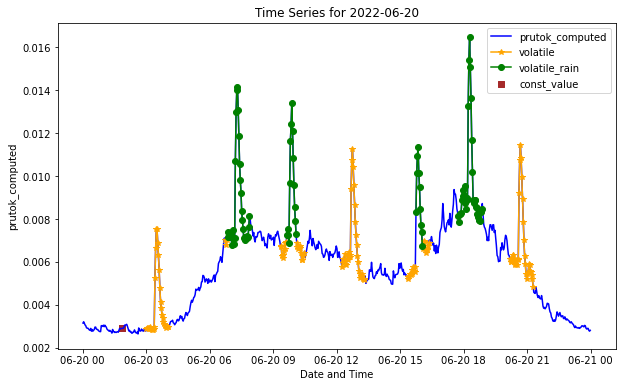

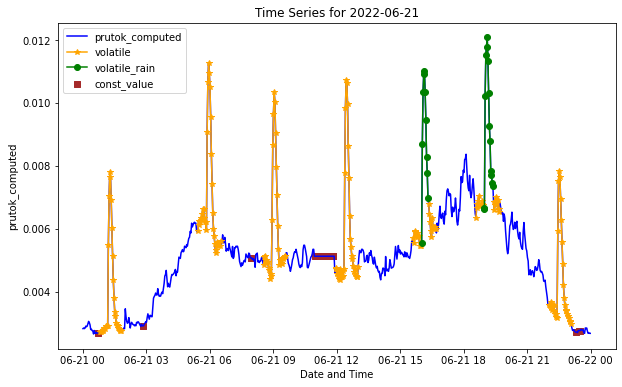

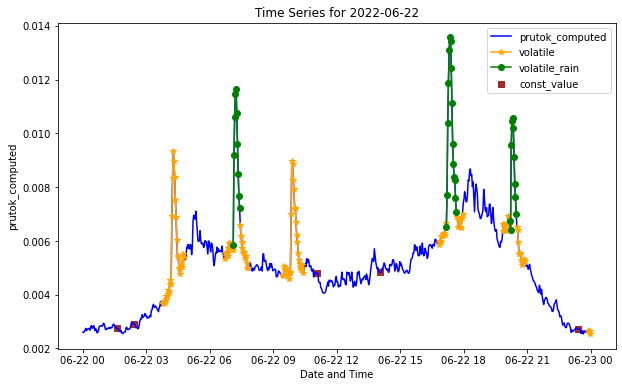

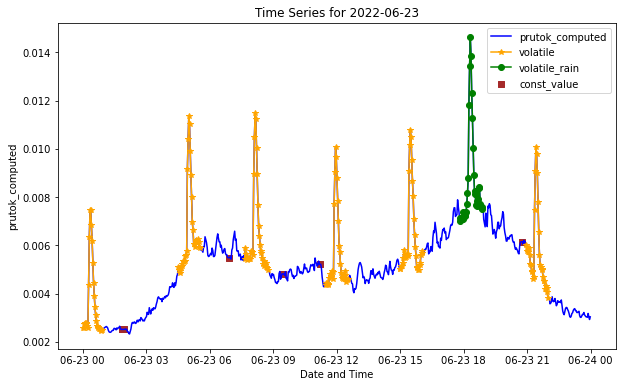

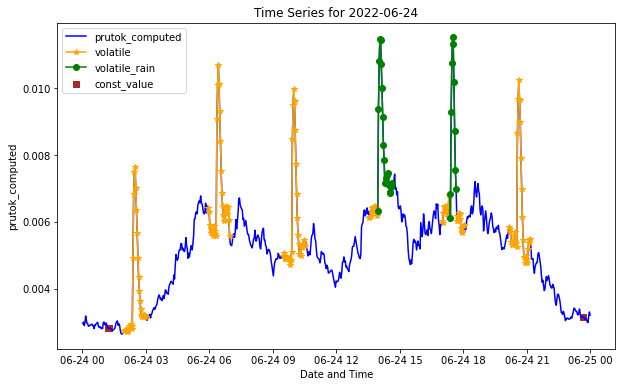

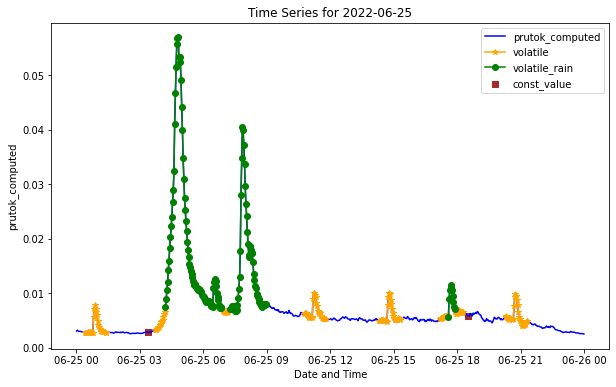

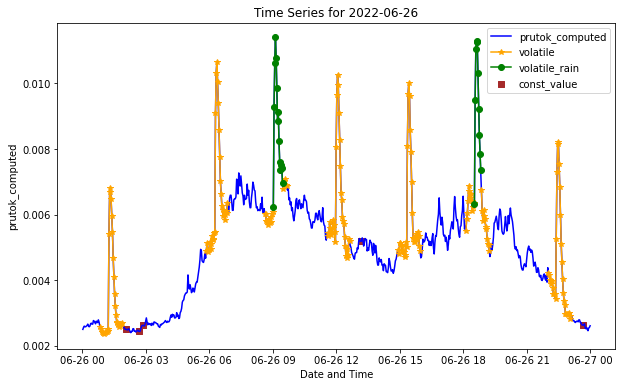

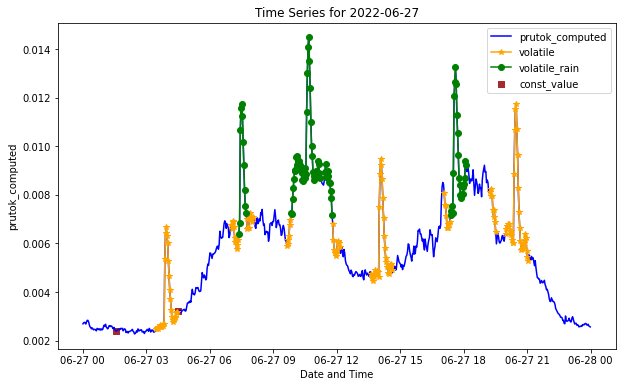

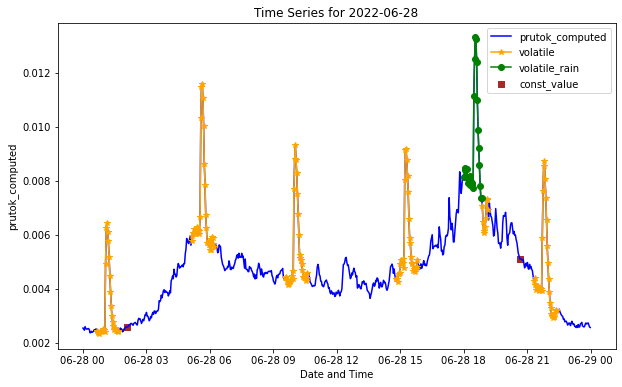

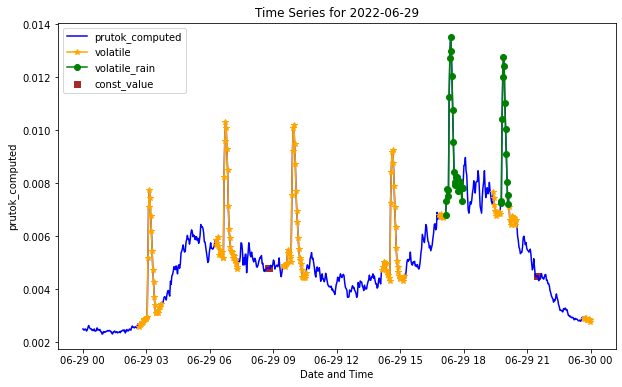

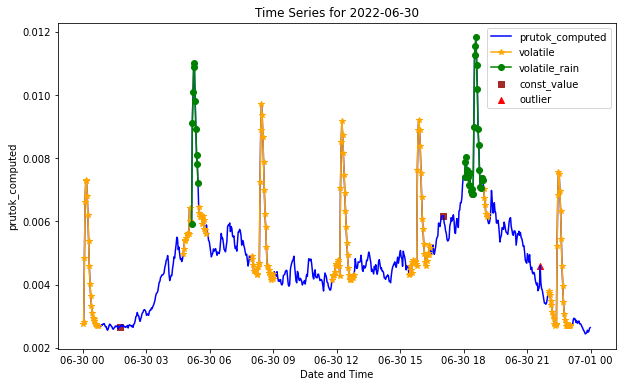

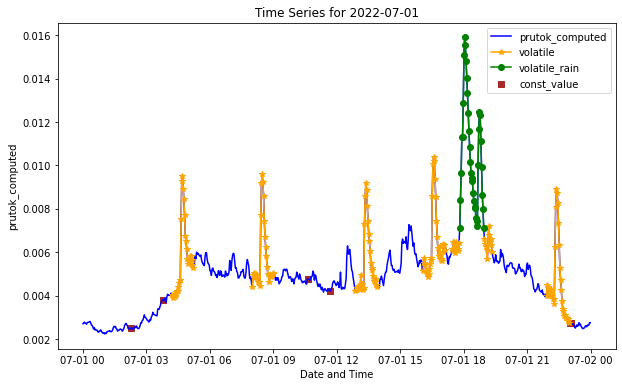

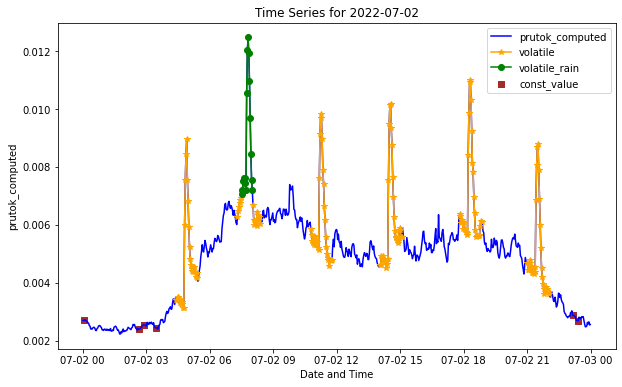

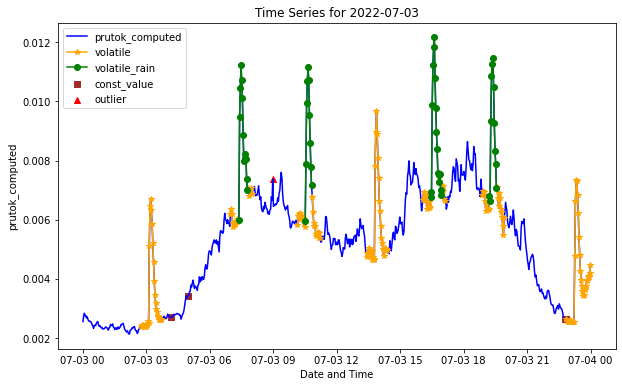

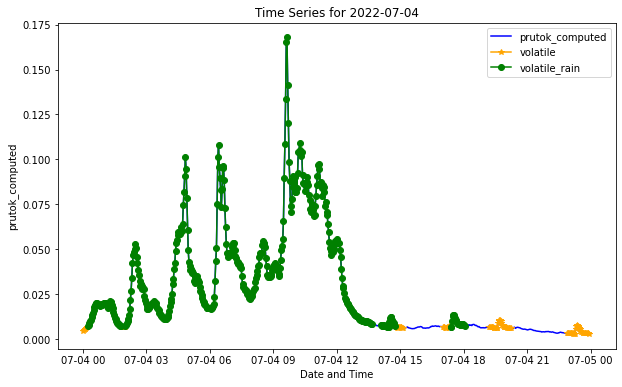

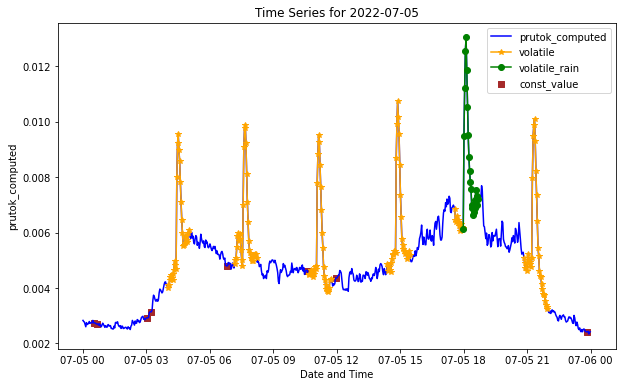

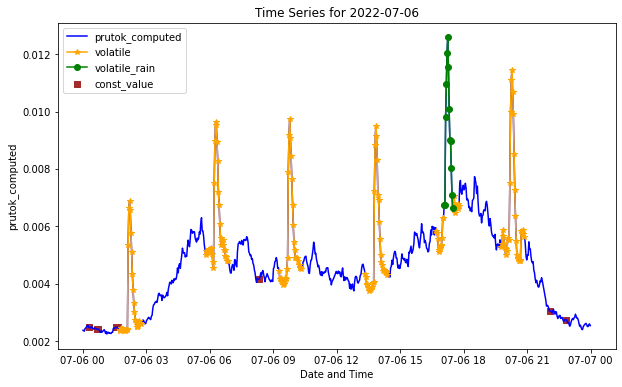

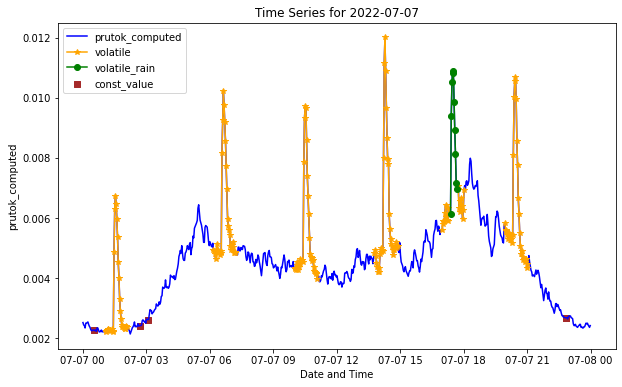

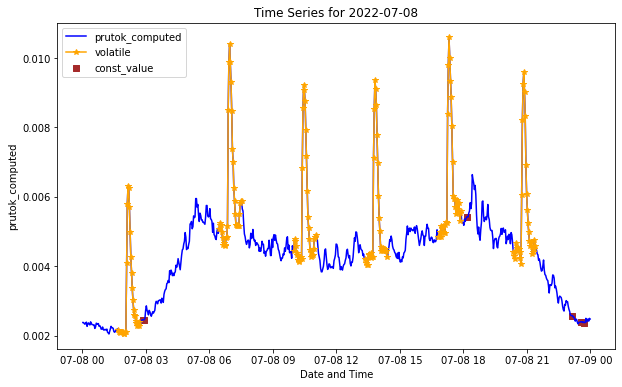

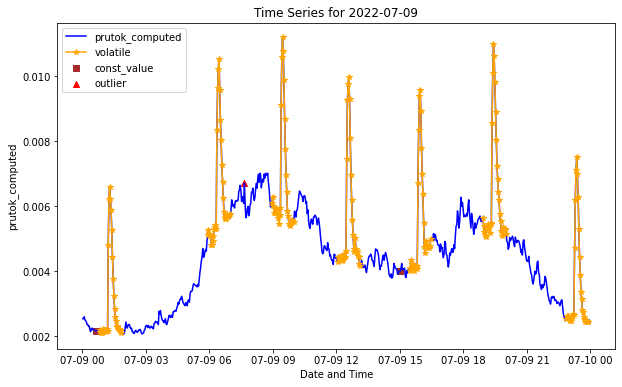

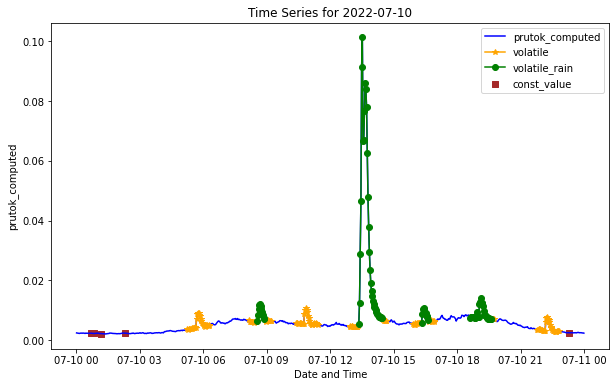

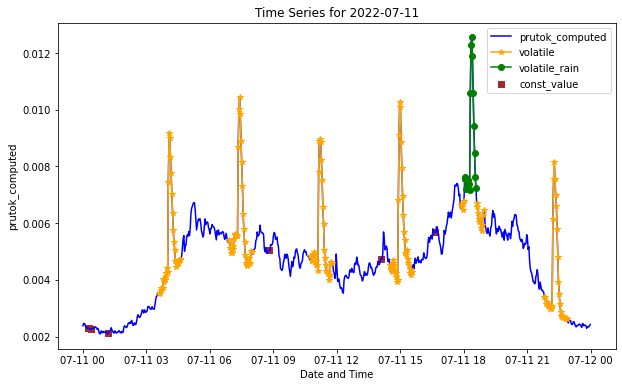

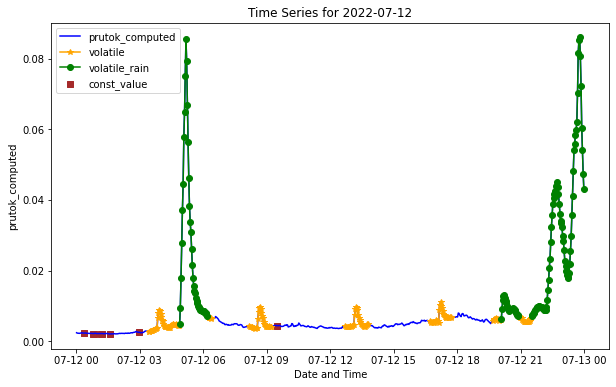

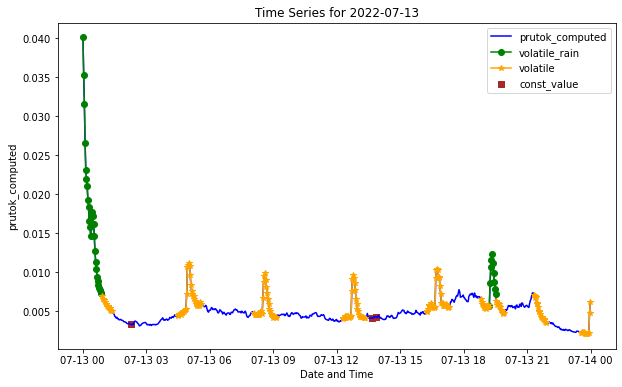

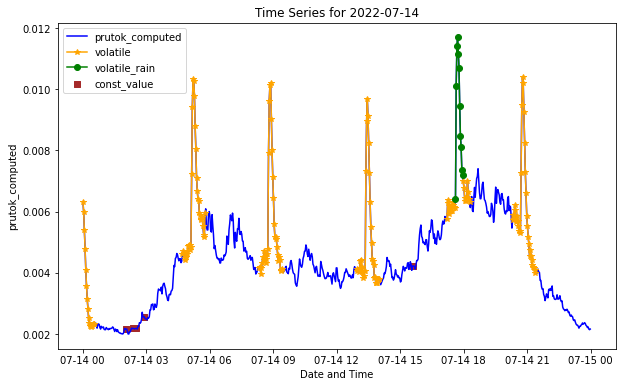

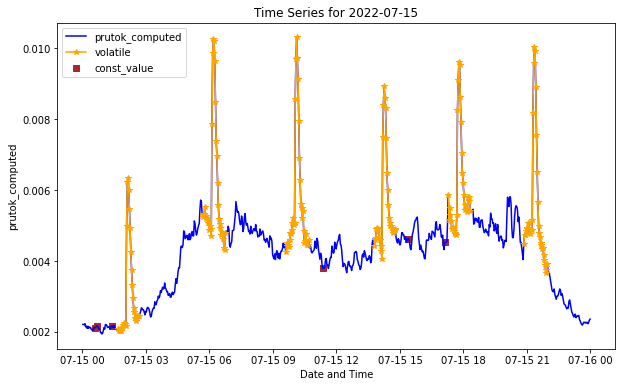

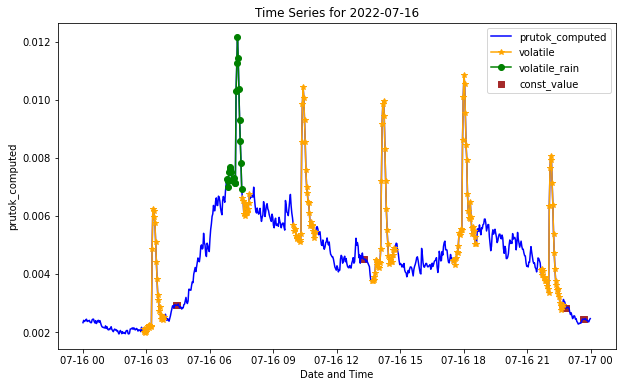

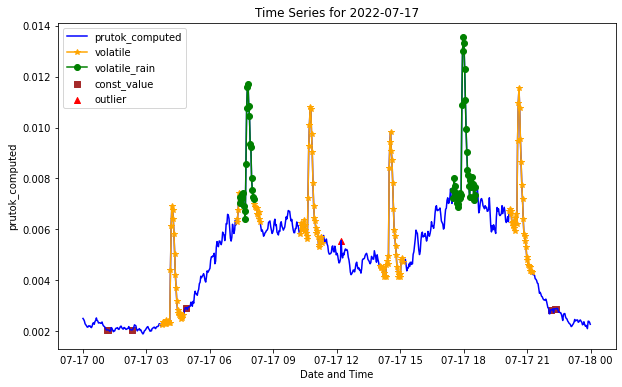

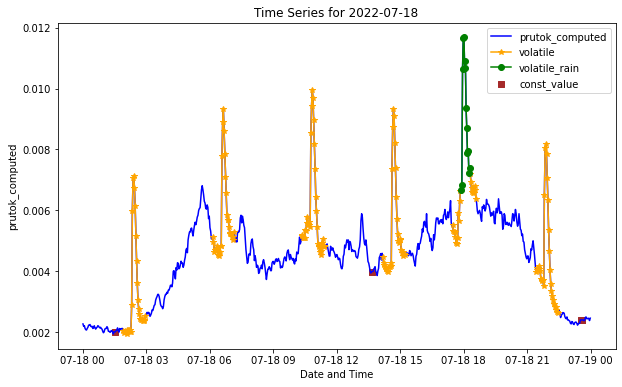

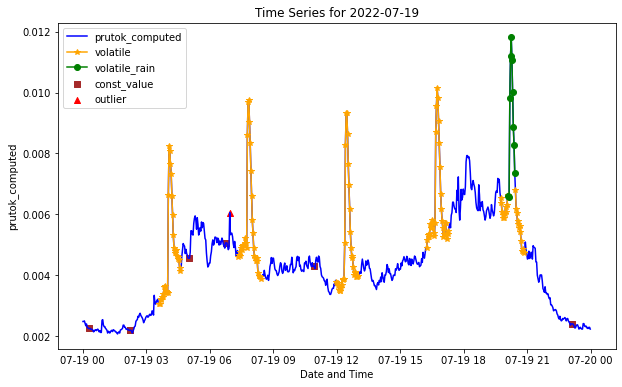

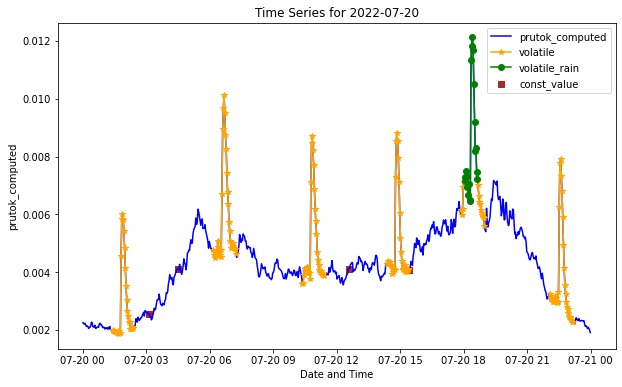

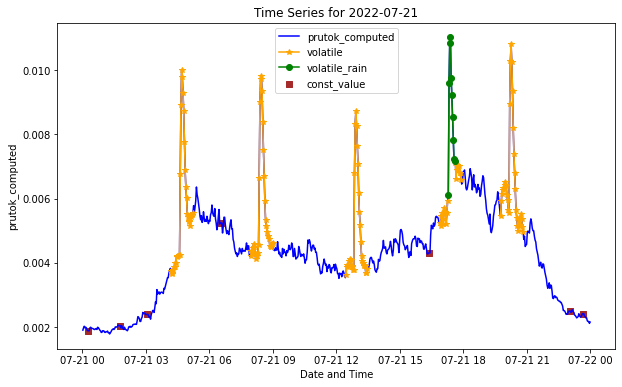

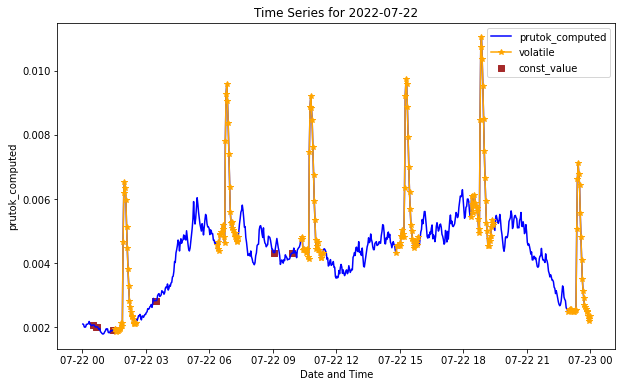

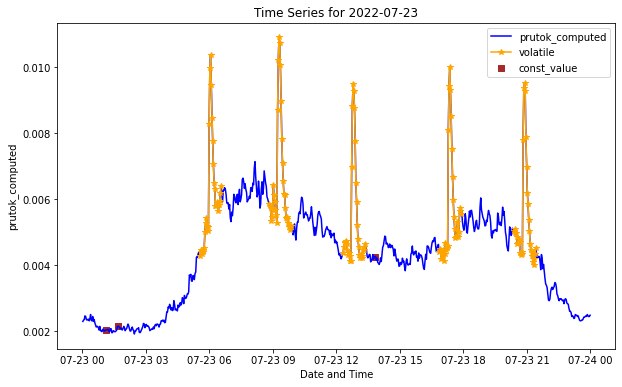

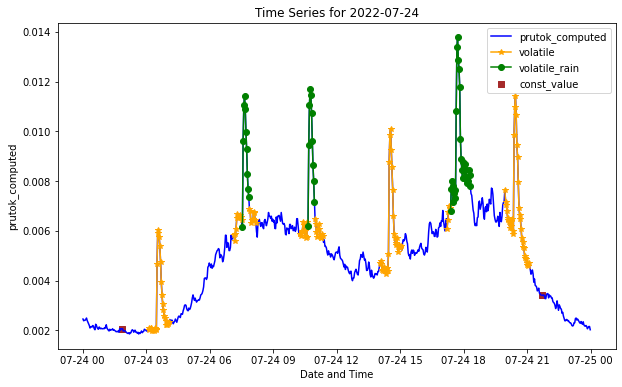

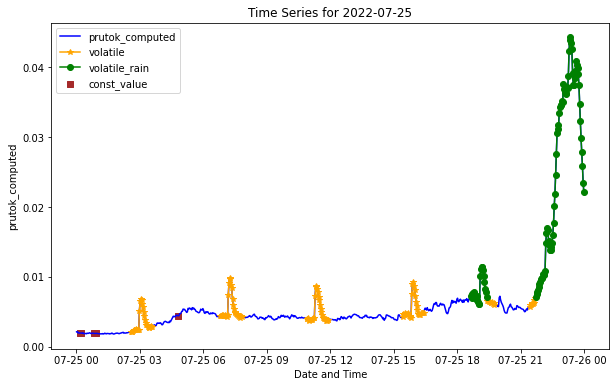

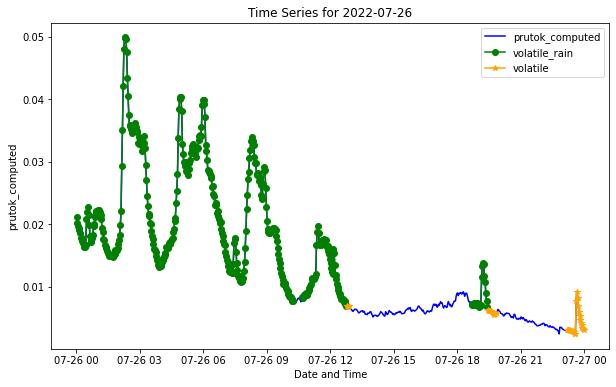

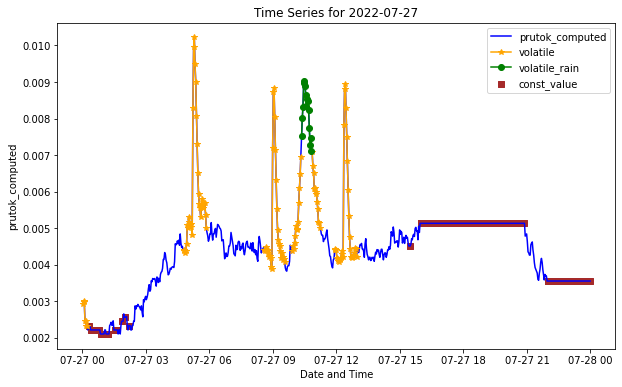

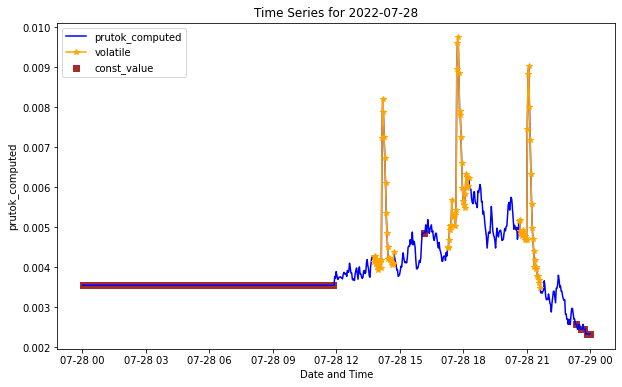

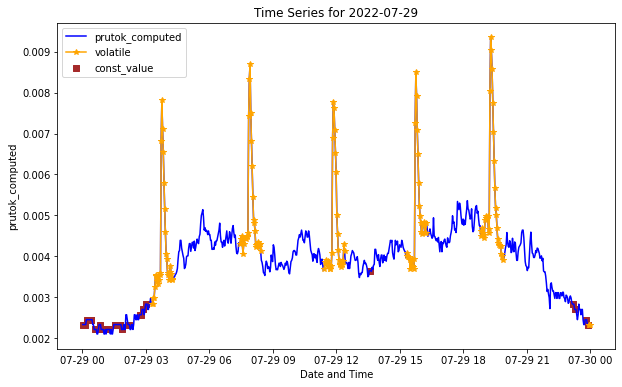

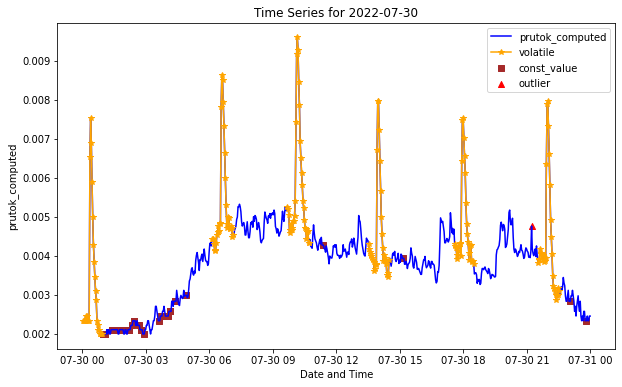

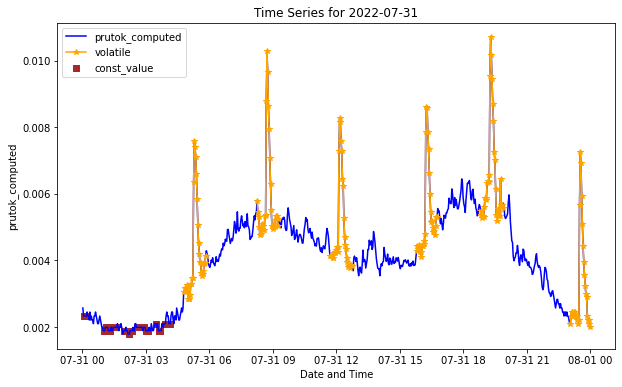

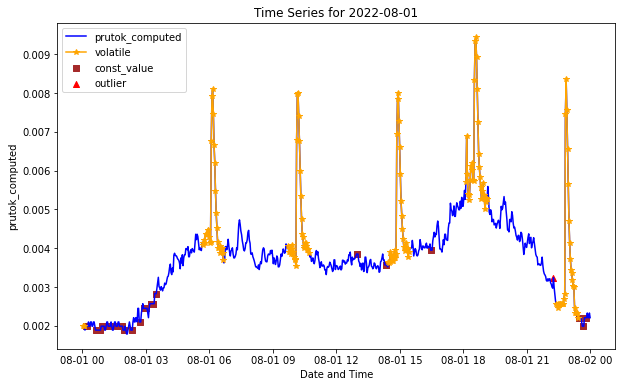

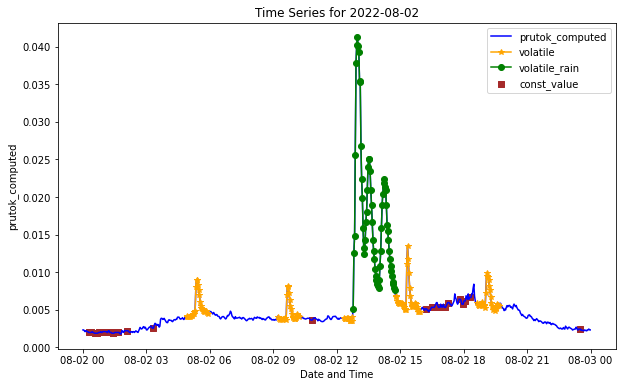

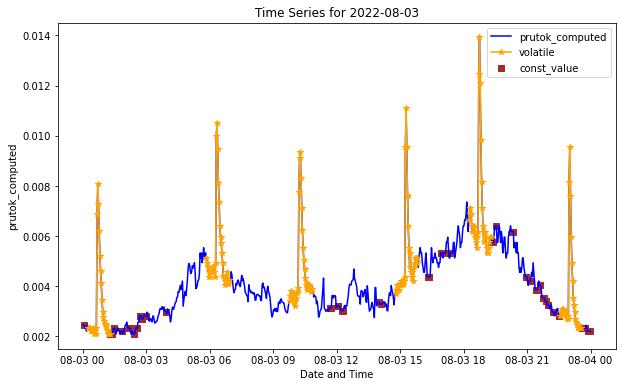

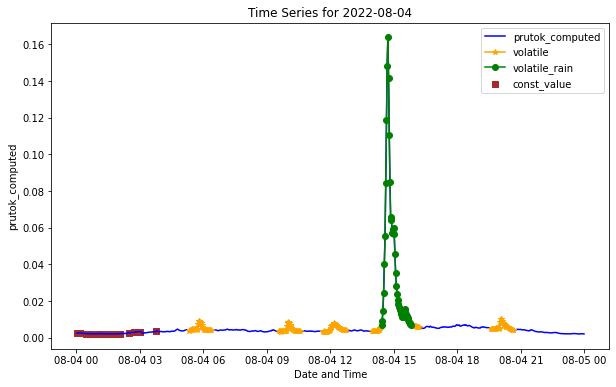

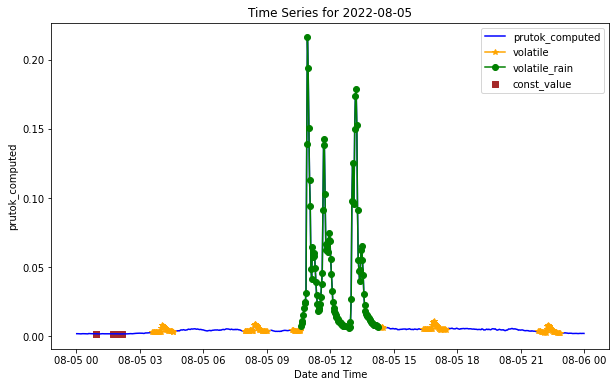

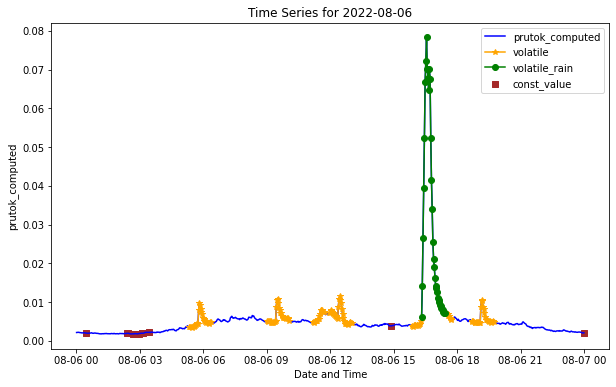

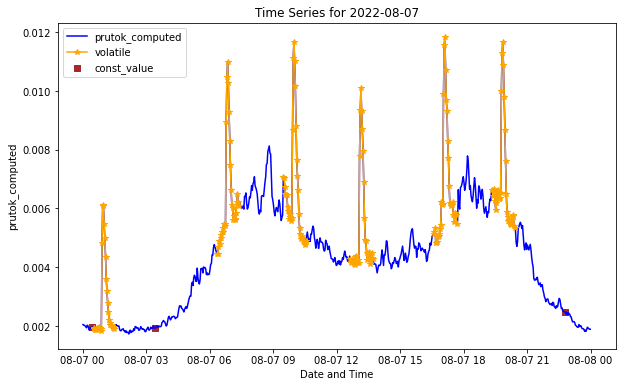

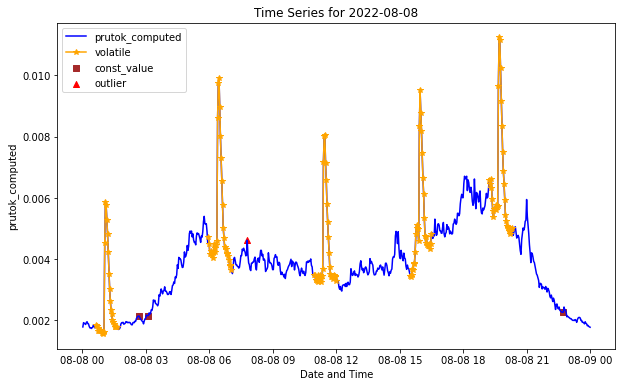

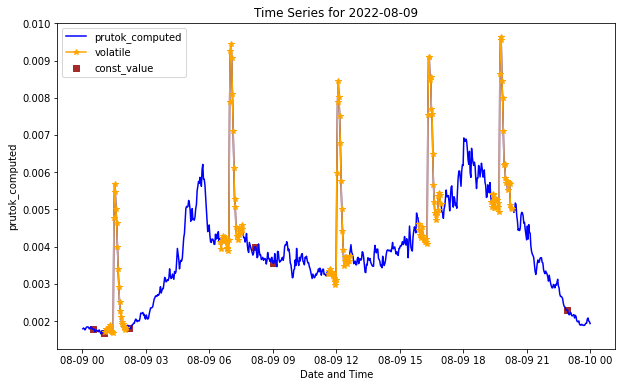

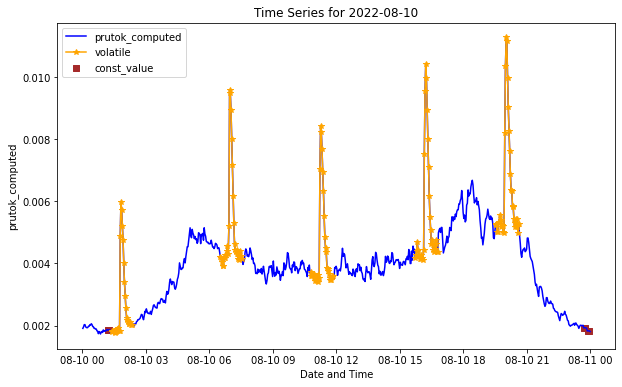

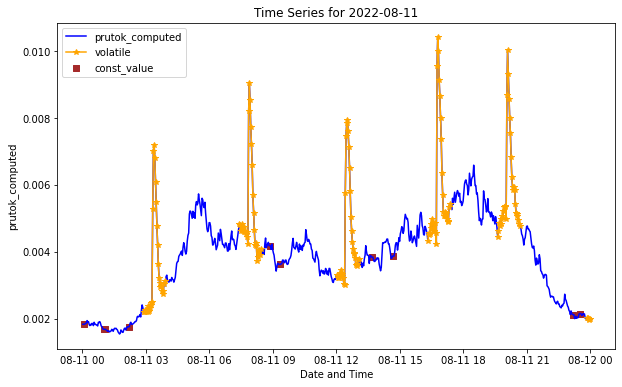

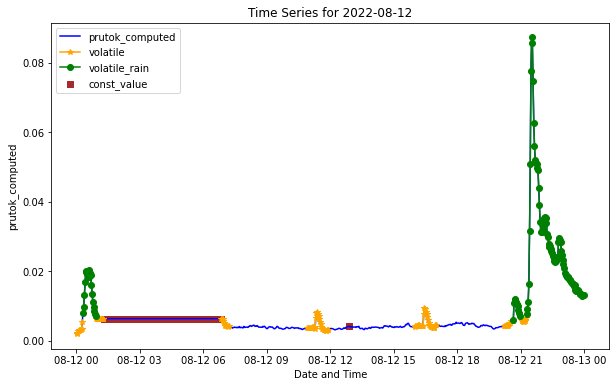

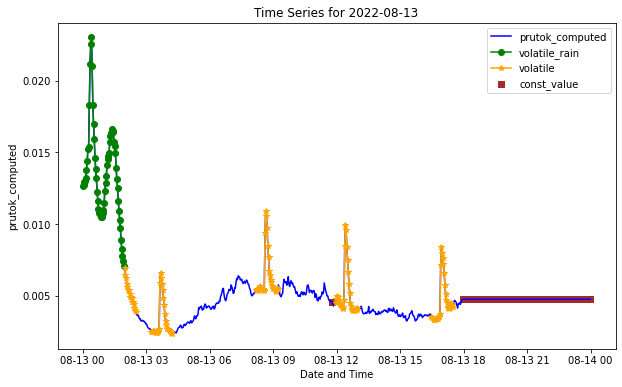

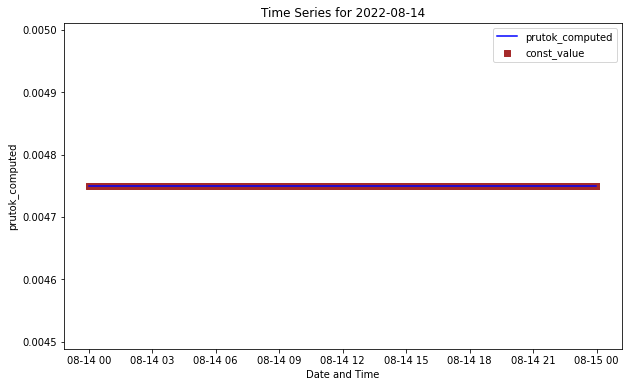

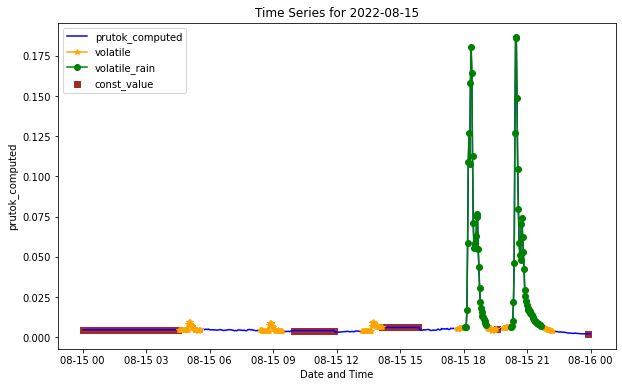

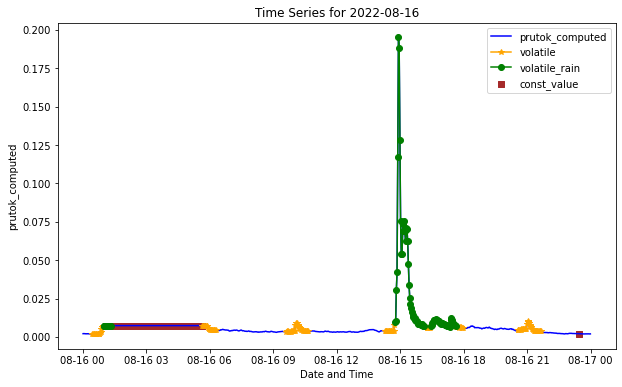

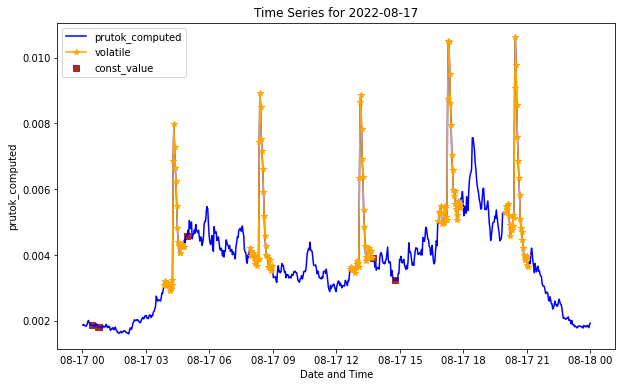

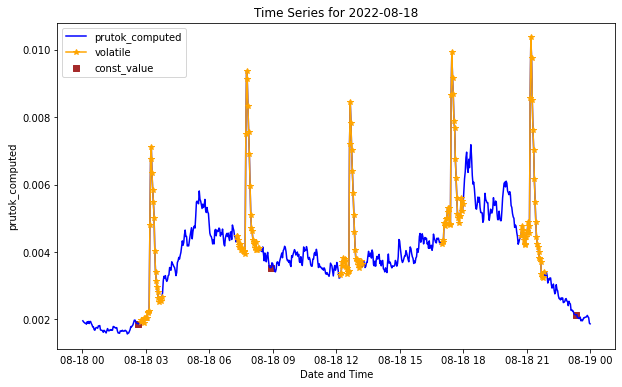

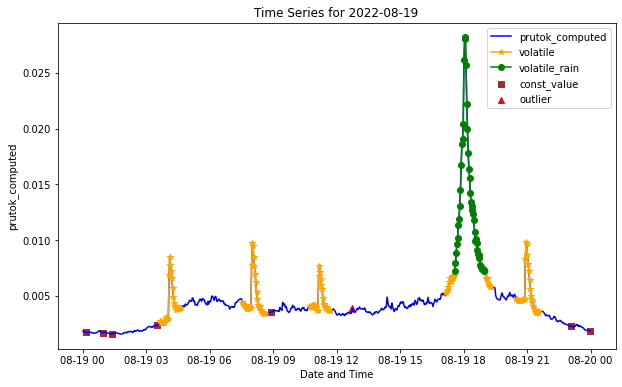

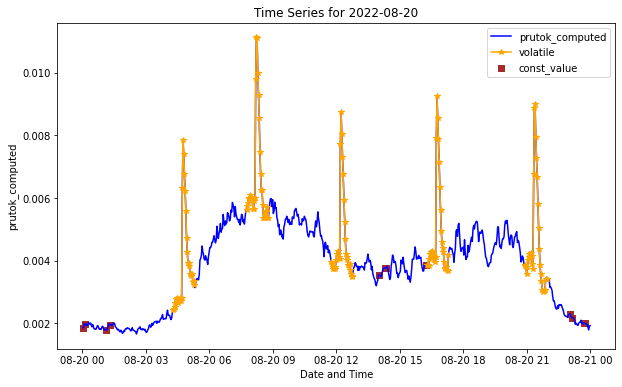

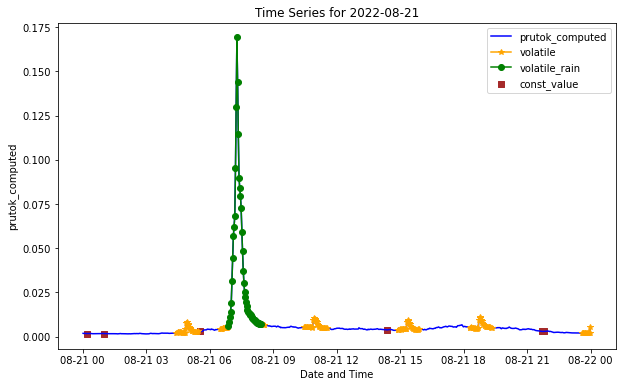

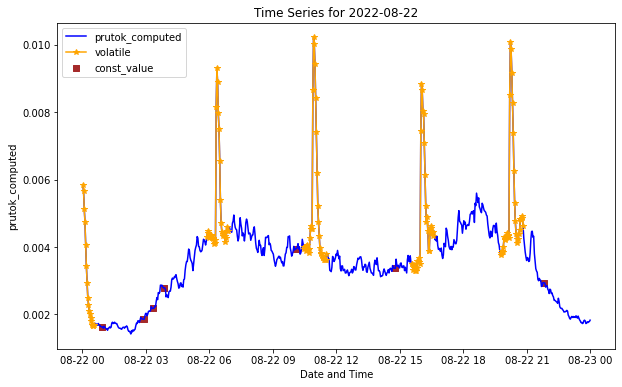

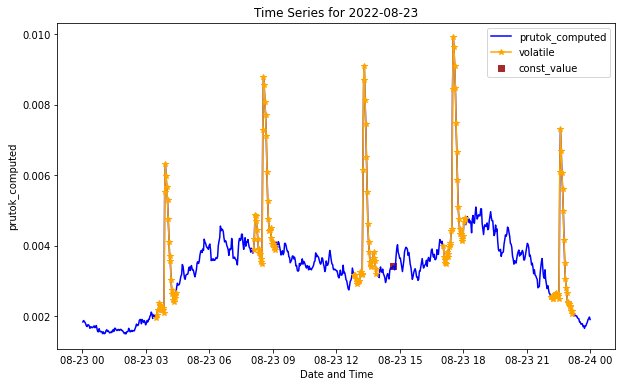

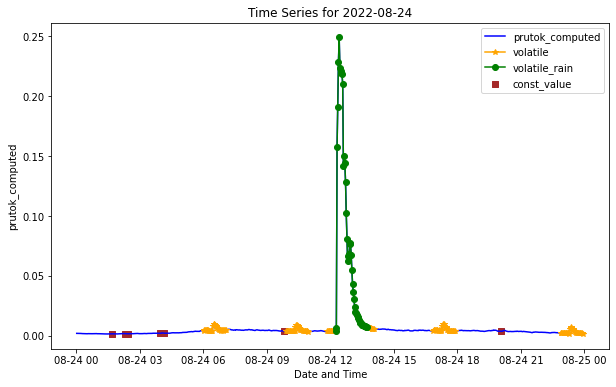

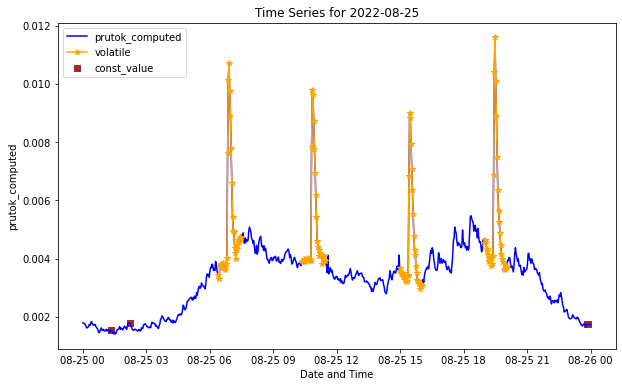

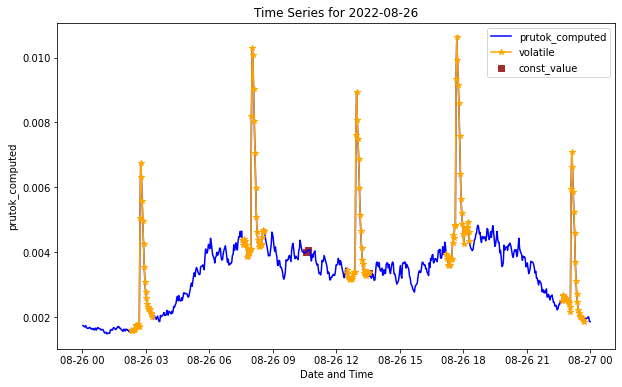

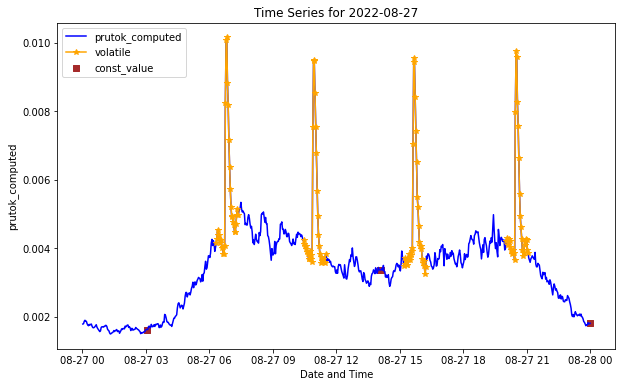

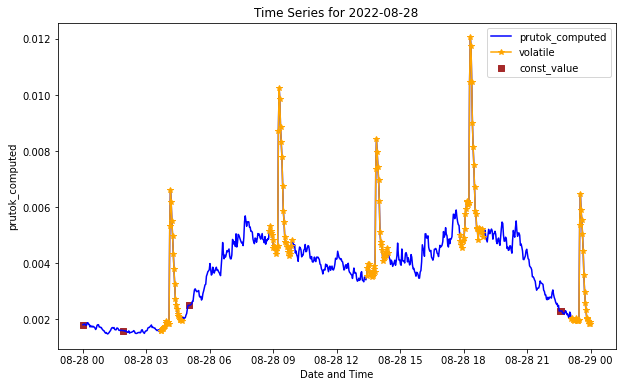

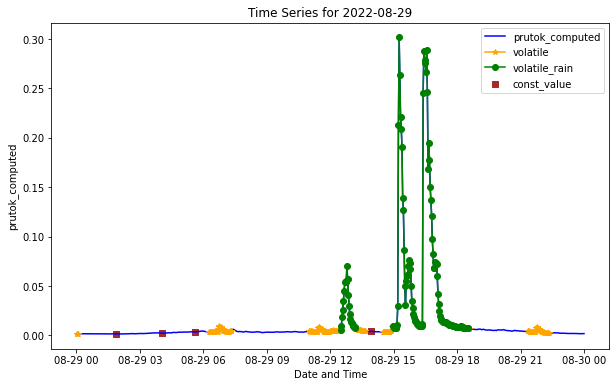

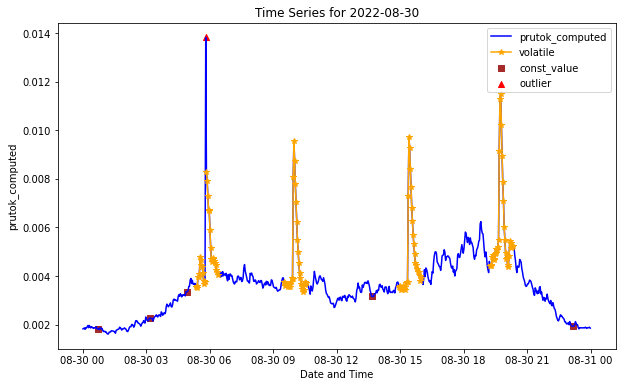

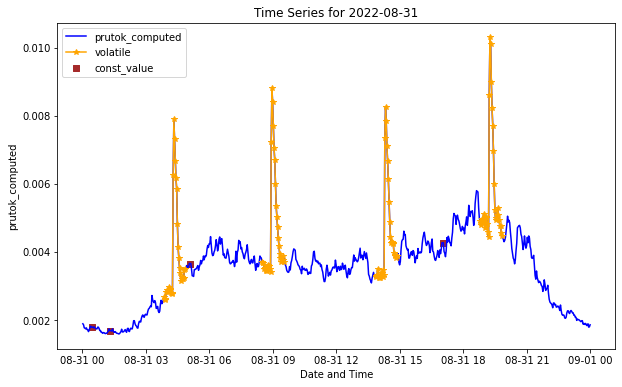

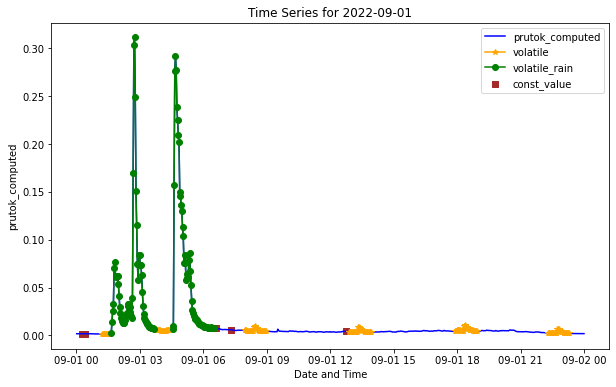

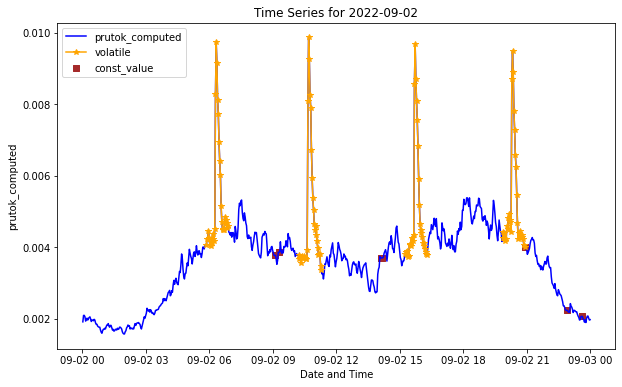

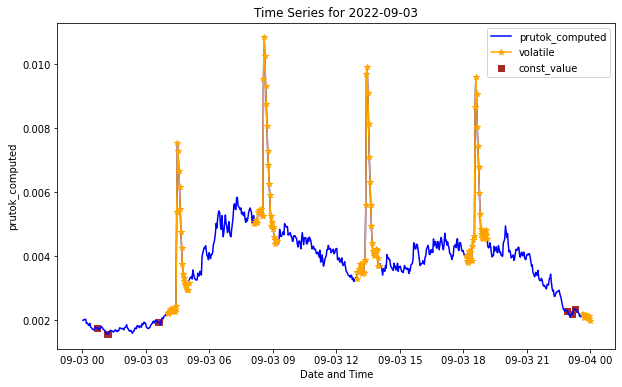

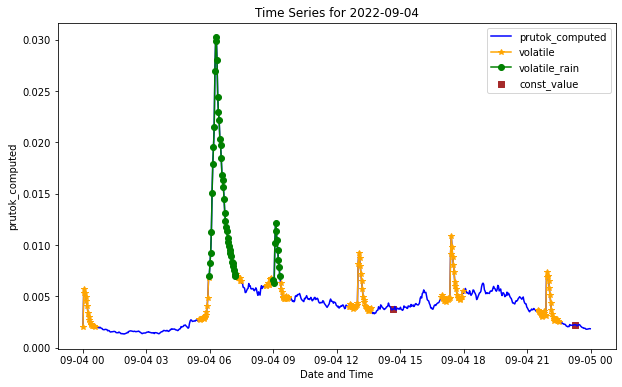

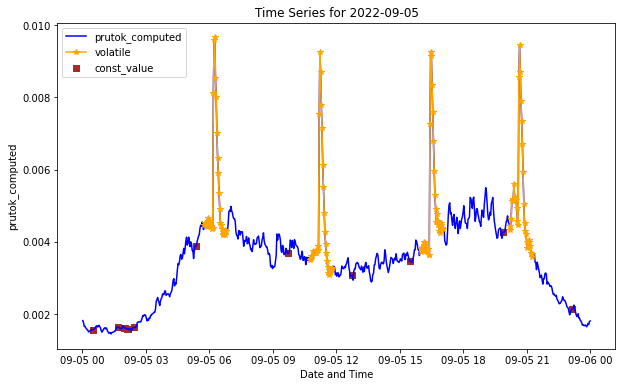

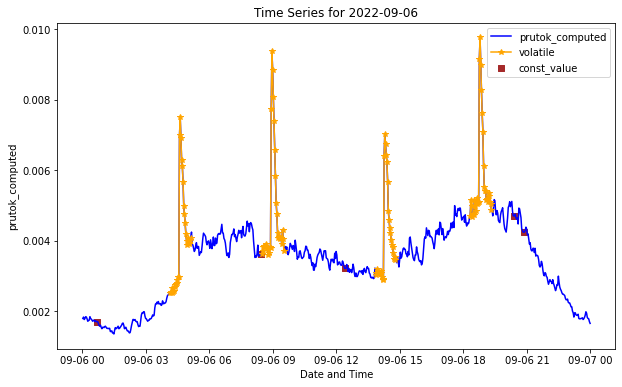

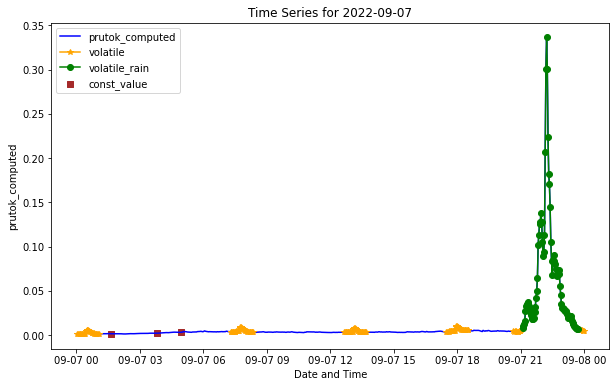

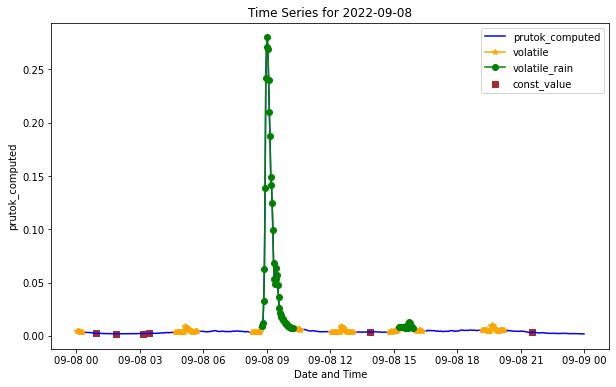

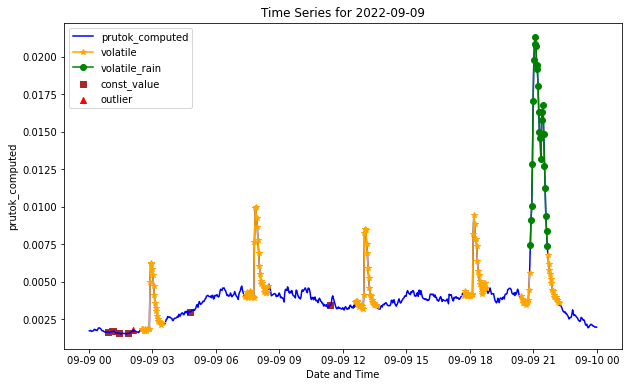

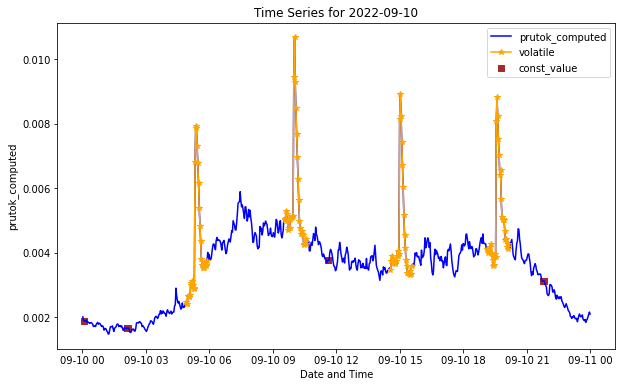

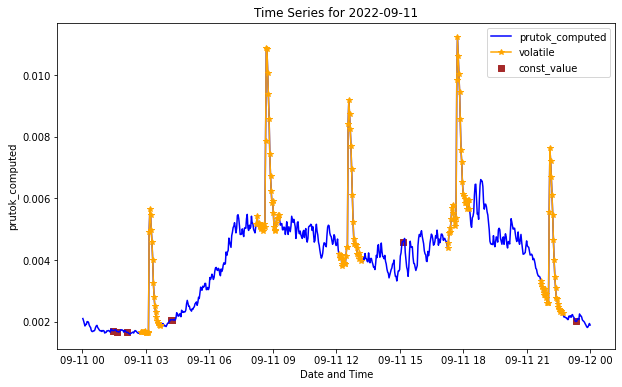

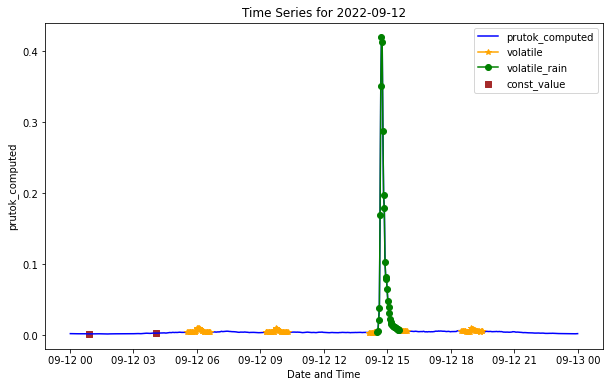

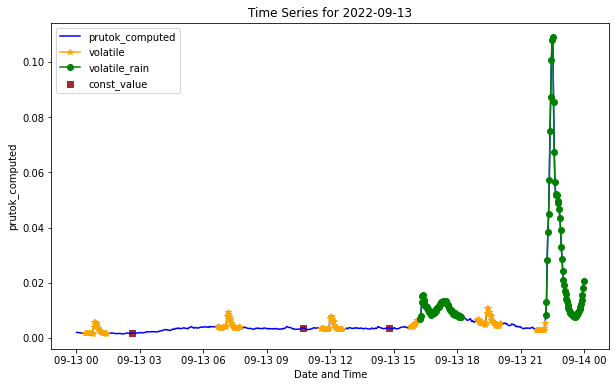

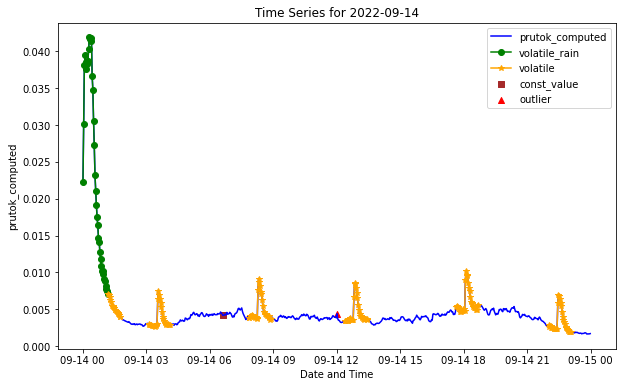

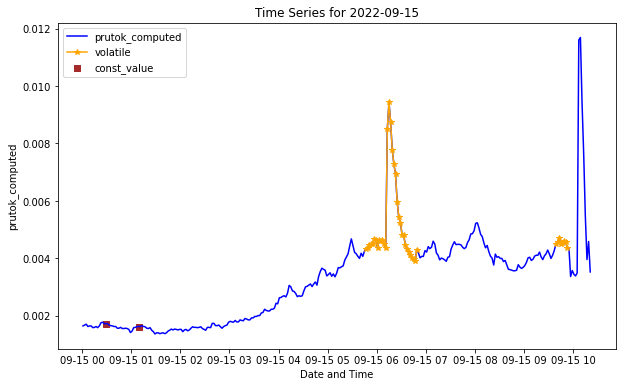

In [35]:
ts_data2_c.plot_categories(period = "daily")  # volatility of flow itself

### summaries of categories

In [65]:
summaries = []
for site in explorer.main_sites:
    summary = summarize_event_groups(explorer.TS_objects[site].data, classif_var="prutok_computed")
    cols = list(summary.columns)
    summary["site"] = site
    summary["var"] = "prutok_computed"
    cols = ["site", "var"] + cols
    summaries.append(summary[cols])
    if site=="first":
        continue
    varies = vars_of_interest[site]
    for var in varies:
        summary = summarize_event_groups(explorer.TS_objects[site].data, classif_var=var)
        cols = list(summary.columns)
        summary["site"] = site
        summary["var"] = var
        cols = ["site", "var"] + cols
        summaries.append(summary[cols])

In [66]:
summies_df = pd.concat(summaries)
i=-1

In [67]:
i+=1
summies_df[summies_df["site"]==explorer.main_sites[i]].sort_values("category")

site              var       category    count  count_perc  max_group  \
0  MP1  prutok_computed             OK  52370.0    0.650785     2549.0   
0  MP1   hladina_result             OK  27246.0    0.338577     1030.0   
0  MP1  rychlost_result             OK  34267.0    0.425825      587.0   
1  MP1  prutok_computed    const_value    351.0    0.004362      177.0   
1  MP1   hladina_result    const_value    335.0    0.004163      165.0   
1  MP1  rychlost_result    const_value    317.0    0.003939      167.0   
2  MP1  prutok_computed        outlier     20.0    0.000249        1.0   
2  MP1   hladina_result        outlier     29.0    0.000360        1.0   
2  MP1  rychlost_result        outlier      1.0    0.000012        1.0   
3  MP1  prutok_computed       volatile  20053.0    0.249192      424.0   
3  MP1   hladina_result       volatile  45306.0    0.563003      590.0   
3  MP1  rychlost_result       volatile  41416.0    0.514663      628.0   
4  MP1  prutok_computed  volatile_rain   7678.0    0.095412      878.0   
4  MP1   hladina_result  volatile_rain   7556.0    0.093896      880.0   
4  MP1  rychlost_result  volatile_rain   4471.0    0.055560      308.0   

   mean_group  med_group  min_group  no_groups  
0  126.192771       43.0        4.0      415.0  
0   52.295585       26.0        1.0      521.0  
0   59.594783       29.0        5.0      575.0  
1  175.500000      175.5      174.0        2.0  
1  111.666667      165.0        5.0        3.0  
1  158.500000      158.5      150.0        2.0  
2    1.000000        1.0        1.0       20.0  
2    1.000000        1.0        1.0       29.0  
2    1.000000        1.0        1.0        1.0  
3   43.032189       31.0        3.0      466.0  
3   77.979346       48.0        1.0      581.0  
3   68.797342       37.0        1.0      602.0  
4   88.252874       56.0       10.0       87.0  
4   89.952381       60.0        5.0       84.0  
4   36.647541       27.0       10.0      122.0

In [68]:
i+=1
summies_df[summies_df["site"]==explorer.main_sites[i]].sort_values("category")

site              var       category    count  count_perc  max_group  \
0  MP2  prutok_computed             OK  62388.0    0.941649     4883.0   
0  MP2   hladina_result             OK  46741.0    0.705482      180.0   
0  MP2  rychlost_result             OK  49824.0    0.752015      414.0   
1  MP2  prutok_computed    const_value   2193.0    0.033100     1047.0   
1  MP2   hladina_result    const_value   3692.0    0.055725     1036.0   
1  MP2  rychlost_result    const_value   2148.0    0.032421     1042.0   
2  MP2  prutok_computed        outlier     13.0    0.000196        1.0   
2  MP2   hladina_result        outlier     13.0    0.000196        1.0   
2  MP2  rychlost_result        outlier      6.0    0.000091        1.0   
3  MP2  prutok_computed       volatile    277.0    0.004181       15.0   
3  MP2   hladina_result       volatile  13125.0    0.198101       64.0   
3  MP2  rychlost_result       volatile  11383.0    0.171808       77.0   
4  MP2  prutok_computed  volatile_rain   1383.0    0.020874      137.0   
4  MP2   hladina_result  volatile_rain   2683.0    0.040496      103.0   
4  MP2  rychlost_result  volatile_rain   2893.0    0.043665      273.0   

   mean_group  med_group  min_group  no_groups  
0  878.704225      479.0        2.0       71.0  
0   62.571620       65.0        1.0      747.0  
0  101.268293       92.5        1.0      492.0  
1   91.375000        8.5        5.0       24.0  
1   14.038023        6.0        1.0      263.0  
1   93.391304        9.0        5.0       23.0  
2    1.000000        1.0        1.0       13.0  
2    1.000000        1.0        1.0       13.0  
2    1.000000        1.0        1.0        6.0  
3    9.892857       11.0        1.0       28.0  
3   25.436047       30.0        1.0      516.0  
3   23.230612       25.0        1.0      490.0  
4   41.909091       35.0       16.0       33.0  
4   27.377551       24.0       10.0       98.0  
4   31.791209       20.0       10.0       91.0

In [69]:
i+=1
summies_df[summies_df["site"]==explorer.main_sites[i]].sort_values("category")

site              var       category    count  count_perc  max_group  \
0  MP3  prutok_computed             OK  78633.0    0.973663    16246.0   
0  MP3   hladina_result             OK  77763.0    0.962890     9509.0   
0  MP3  rychlost_result             OK  69360.0    0.858841     4766.0   
1  MP3  prutok_computed    const_value    178.0    0.002204      178.0   
1  MP3   hladina_result    const_value    178.0    0.002204      178.0   
2  MP3  prutok_computed        outlier      1.0    0.000012        1.0   
3  MP3  prutok_computed       volatile    558.0    0.006909       26.0   
2  MP3   hladina_result       volatile   1013.0    0.012543       42.0   
1  MP3  rychlost_result       volatile  10575.0    0.130944      295.0   
4  MP3  prutok_computed  volatile_rain   1356.0    0.016790      103.0   
3  MP3   hladina_result  volatile_rain   1806.0    0.022363      126.0   
2  MP3  rychlost_result  volatile_rain    791.0    0.009794      107.0   
5  MP3  prutok_computed     zero_value     34.0    0.000421        8.0   
3  MP3  rychlost_result     zero_value     34.0    0.000421        8.0   

    mean_group  med_group  min_group  no_groups  
0  1747.400000      330.0        5.0       45.0  
0  1654.531915      904.0        9.0       47.0  
0   352.081218       75.0        5.0      197.0  
1   178.000000      178.0      178.0        1.0  
1   178.000000      178.0      178.0        1.0  
2     1.000000        1.0        1.0        1.0  
3    10.528302       12.0        1.0       53.0  
2    15.584615       13.0        1.0       65.0  
1    50.118483       34.0        3.0      211.0  
4    31.534884       24.0       10.0       43.0  
3    37.625000       24.0       10.0       48.0  
2    28.250000       16.5       10.0       28.0  
5     4.857143        6.0        1.0        7.0  
3     4.857143        6.0        1.0        7.0

In [70]:
i+=1
summies_df[summies_df["site"]==explorer.main_sites[i]].sort_values("category")

site              var       category    count  count_perc  max_group  \
0  MP4  prutok_computed             OK  54875.0    0.785477     7588.0   
0  MP4   hladina_result             OK  46056.0    0.659243     7560.0   
0  MP4  rychlost_result             OK  34133.0    0.488577     6293.0   
1  MP4  prutok_computed    const_value    315.0    0.004509      165.0   
1  MP4   hladina_result    const_value    329.0    0.004709      165.0   
1  MP4  rychlost_result    const_value    325.0    0.004652      163.0   
2  MP4   hladina_result        outlier      2.0    0.000029        1.0   
2  MP4  prutok_computed       volatile   8191.0    0.117245      179.0   
3  MP4   hladina_result       volatile  16957.0    0.242721      526.0   
2  MP4  rychlost_result       volatile  29962.0    0.428874      712.0   
3  MP4  prutok_computed  volatile_rain   6481.0    0.092769      525.0   
4  MP4   hladina_result  volatile_rain   6518.0    0.093298      608.0   
3  MP4  rychlost_result  volatile_rain   5442.0    0.077896      277.0   

   mean_group  med_group  min_group  no_groups  
0  225.823045       58.0        5.0      243.0  
0  148.567742       35.0        5.0      310.0  
0   97.245014       23.0        5.0      351.0  
1  157.500000      157.5      150.0        2.0  
1  164.500000      164.5      164.0        2.0  
1  162.500000      162.5      162.0        2.0  
2    1.000000        1.0        1.0        2.0  
2   28.342561       23.0        1.0      289.0  
3   46.713499       28.0        2.0      363.0  
2   73.798030       40.0        3.0      406.0  
3   87.581081       39.0       10.0       74.0  
4   97.283582       48.0       13.0       67.0  
3   42.850394       29.0       10.0      127.0

In [71]:
i+=1
summies_df[summies_df["site"]==explorer.main_sites[i]].sort_values("category")

site              var       category    count  count_perc  max_group  \
0  MP5  prutok_computed             OK  72590.0    0.961839     8553.0   
0  MP5   hladina_result             OK  72138.0    0.955850     6342.0   
0  MP5  rychlost_result             OK  51739.0    0.685557      538.0   
1  MP5  prutok_computed    const_value   2197.0    0.029111     1078.0   
1  MP5   hladina_result    const_value   1827.0    0.024208     1079.0   
1  MP5  rychlost_result    const_value   1749.0    0.023175     1077.0   
2  MP5  rychlost_result        outlier      1.0    0.000013        1.0   
2  MP5  prutok_computed       volatile     87.0    0.001153       11.0   
2  MP5   hladina_result       volatile    218.0    0.002889       13.0   
3  MP5  rychlost_result       volatile  17021.0    0.225533      211.0   
3  MP5  prutok_computed  volatile_rain    596.0    0.007897       67.0   
3  MP5   hladina_result  volatile_rain   1287.0    0.017053       76.0   
4  MP5  rychlost_result  volatile_rain   4960.0    0.065721      695.0   

    mean_group  med_group  min_group  no_groups  
0   789.021739      518.5        2.0       92.0  
0  1414.470588      779.0       13.0       51.0  
0    96.348231       44.0        5.0      537.0  
1    30.513889        6.0        5.0       72.0  
1   166.090909       22.0        5.0       11.0  
1   349.800000      178.0       28.0        5.0  
2     1.000000        1.0        1.0        1.0  
2     6.692308        6.0        1.0       13.0  
2     9.909091       11.0        2.0       22.0  
3    28.898132       26.0        1.0      589.0  
3    33.111111       31.0       19.0       18.0  
3    33.000000       30.0       10.0       39.0  
4    49.108911       23.0       10.0      101.0

In [72]:
i+=1
summies_df[summies_df["site"]==explorer.main_sites[i]].sort_values("category")

site              var       category    count  count_perc  max_group  \
0  MP6  prutok_computed             OK  67752.0    0.904518     4481.0   
0  MP6   hladina_result             OK  69426.0    0.926866     6530.0   
0  MP6  rychlost_result             OK  19580.0    0.261401     4488.0   
1  MP6  prutok_computed    const_value    209.0    0.002790      177.0   
1  MP6   hladina_result    const_value    442.0    0.005901      177.0   
1  MP6  rychlost_result    const_value    621.0    0.008291      178.0   
2  MP6  prutok_computed        outlier      8.0    0.000107        1.0   
2  MP6  rychlost_result        outlier     23.0    0.000307        1.0   
3  MP6  prutok_computed       volatile   1957.0    0.026127      164.0   
2  MP6   hladina_result       volatile   1623.0    0.021668      166.0   
3  MP6  rychlost_result       volatile  48260.0    0.644291     1141.0   
4  MP6  prutok_computed  volatile_rain   4978.0    0.066458      642.0   
3  MP6   hladina_result  volatile_rain   3413.0    0.045565      608.0   
4  MP6  rychlost_result  volatile_rain   6420.0    0.085710      878.0   

   mean_group  med_group  min_group  no_groups  
0  509.413534      211.0        4.0      133.0  
0  564.439024      301.0        5.0      123.0  
0   41.571125       17.0        1.0      471.0  
1   29.857143        5.0        5.0        7.0  
1    9.608696        6.0        5.0       46.0  
1    7.392857        5.0        1.0       84.0  
2    1.000000        1.0        1.0        8.0  
2    1.000000        1.0        1.0       23.0  
3   17.954128       14.0        1.0      109.0  
2   21.640000       16.0        1.0       75.0  
3   97.692308       50.0        5.0      494.0  
4   67.270270       40.5        1.0       74.0  
3   72.617021       55.0       10.0       47.0  
4   64.200000       41.0        5.0      100.0

In [73]:
i+=1
summies_df[summies_df["site"]==explorer.main_sites[i]].sort_values("category")

site               var       category    count  count_perc  max_group  \
0  MP7   prutok_computed             OK  58649.0    0.881821    11348.0   
0  MP7  hladina_TL_zdroj             OK  63109.0    0.948879     4359.0   
0  MP7    rychlost_zdroj             OK  44271.0    0.665639     5402.0   
1  MP7  hladina_TL_zdroj    const_value    592.0    0.008901       15.0   
1  MP7    rychlost_zdroj    const_value     23.0    0.000346       13.0   
1  MP7   prutok_computed        outlier     49.0    0.000737        2.0   
2  MP7  hladina_TL_zdroj        outlier      5.0    0.000075        1.0   
2  MP7    rychlost_zdroj        outlier     58.0    0.000872        1.0   
2  MP7   prutok_computed       volatile    554.0    0.008330       38.0   
3  MP7  hladina_TL_zdroj       volatile    622.0    0.009352      133.0   
3  MP7    rychlost_zdroj       volatile  11235.0    0.168925      212.0   
3  MP7   prutok_computed  volatile_rain   1940.0    0.029169      165.0   
4  MP7  hladina_TL_zdroj  volatile_rain   2181.0    0.032793      227.0   
4  MP7    rychlost_zdroj  volatile_rain   5603.0    0.084244      749.0   
4  MP7   prutok_computed     zero_value   5317.0    0.079944     3059.0   
5  MP7    rychlost_zdroj     zero_value   5319.0    0.079974     3059.0   

   mean_group  med_group  min_group  no_groups  
0  637.489130      337.0        1.0       92.0  
0  423.550336      256.0        1.0      149.0  
0  186.012605       41.5        1.0      238.0  
1    5.979798        5.0        5.0       99.0  
1    7.666667        5.0        5.0        3.0  
1    1.020833        1.0        1.0       48.0  
2    1.000000        1.0        1.0        5.0  
2    1.000000        1.0        1.0       58.0  
2   10.259259        7.0        1.0       54.0  
3   17.277778       14.0        1.0       36.0  
3   31.737288       19.0        1.0      354.0  
3   30.312500       15.0        1.0       64.0  
4   57.394737       46.5       12.0       38.0  
4   41.503704       20.0        1.0      135.0  
4   83.078125        3.0        1.0       64.0  
5   83.109375        3.0        1.0       64.0

In [74]:
i+=1
summies_df[summies_df["site"]==explorer.main_sites[i]].sort_values("category")

site              var       category    count  count_perc  max_group  \
0  first  prutok_computed             OK  15324.0    0.686559      954.0   
1  first  prutok_computed        outlier     47.0    0.002106        1.0   
2  first  prutok_computed       volatile   5179.0    0.232034      315.0   
3  first  prutok_computed  volatile_rain   1644.0    0.073656      118.0   
4  first  prutok_computed     zero_value    126.0    0.005645       28.0   

   mean_group  med_group  min_group  no_groups  
0  111.043478       50.5        1.0      138.0  
1    1.000000        1.0        1.0       47.0  
2   41.432000       21.0        1.0      125.0  
3   33.551020       20.0        5.0       49.0  
4    3.600000        2.0        1.0       35.0